# CSMODEL PHASE 1 - Froggers' Pokemon Analysis

![Tyranitar](assets/tyranitar.gif)![Scizor](assets/scizor.gif)![Keldeo](assets/keldeo.gif)![Terrakion](assets/terrakion.gif)![Jirachi](assets/jirachi.gif)![Latios](assets/latios.gif)

In [98]:
# Imports and Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as sp
import matplotlib.pyplot as plt
import scipy.spatial.distance as spsd
from rule_miner import RuleMiner
from sklearn.cluster import DBSCAN

np.random.seed(0)

## Chapter 1. Introduction

The nature of the data and the rationale behind its application will be discussed in this chapter. Information on how these data are gathered will also be addressed.

### 1.1 The Showdown Data set

The first and main dataset consists of records of a person's Pokemon battle. It specifically has columns of
* The battle's unique ID ("tag"), generated by Pokemon Showdown
* The name of the first player who participated in that battle (player 1)
* That player's elo ranking
* Which six Pokemon they used
* The lead Pokemon (which Pokemon they sent first)
* The turn count (how many turns the battle lasted)
* The result of that battle (win, lose, tie)

While a battle consists of two players each with their own unique features, we will delimit
our study to the scope of one person (player 1 only, and not player 2) and base our analyses from there.

This is because we mostly want to focus on identifying patterns on how a player builds their
teams given the meta irrespective of the other team. In Pokemon Showdown, teams are built
independently before players challenge each other and are not built "on the fly".

The specific data set we chose is matches done in the Generation 5 "Overused" format (Gen5OU). The reason
for this is this is the earliest version where the Pokemon Showdown implemented the feature where
you are able to see all of the opposing Pokemon from your opponent. This is important as it
enabled us to read the team composition of these matches.

#### 1.1.1 Scraping battle logs

Scraping the battle logs was done using a separate JavaScript program created by one of our
group members: [Showdown Scraper](https://github.com/jrgo7/showdown-scraper). Through this program, we were
able to **scrape the last 5000 recorded Gen5OU battles** from the Pokemon Showdown replay catalogue, which is all that
was available for this format. Unfortunately, this brings in a recency bias as we do not have access to the entire
population of Gen5OU Pokemon battles.

#### 1.1.2 Structuring battle logs

The battle logs by themselves are unstructured and are like chat messages in the sense that they are composed of lines
of "messages" that convey some information or action taken. A few examples:

```
|turn|1
```

represents the beginning of turn 1;

```
|poke|p1|Tyranitar, F|item
|poke|p1|Victini|item
|poke|p1|Excadrill, M|item
|poke|p1|Rotom-Wash|item
|poke|p1|Ferrothorn, F|item
|poke|p1|Latios, M|item
```

represents a definition of a set of 6 Pokemon for player 1 (the feature mentioned in section 1.1 which made us choose
this format in particular); and

```
|switch|p1a: Rotom|Rotom-Wash|100/100
```

represents that player 1 switched in ("sent out") the Pokemon named Rotom, who is currently at full HP (100/100).

These lines were parsed and processed into the [`showdown.csv`](./dataset/showdown/showdown.csv) file via the [`battlelogs_to_csv.py`](battlelogs_to_csv.py) script, containing the features mentioned in section 1.1.

In [99]:
showdown_df = pd.read_csv("./dataset/showdown/showdown.csv")
showdown_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 38 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Tag               5000 non-null   int64 
 1   Player            5000 non-null   object
 2   Elo               5000 non-null   int64 
 3   Pokemon 1         5000 non-null   object
 4   Pokemon 2         5000 non-null   object
 5   Pokemon 3         5000 non-null   object
 6   Pokemon 4         5000 non-null   object
 7   Pokemon 5         5000 non-null   object
 8   Pokemon 6         5000 non-null   object
 9   LeadPokemon       4987 non-null   object
 10  TurnCount         5000 non-null   int64 
 11  Result            5000 non-null   object
 12  Pokemon 1 Move 1  3527 non-null   object
 13  Pokemon 1 Move 2  2234 non-null   object
 14  Pokemon 1 Move 3  1046 non-null   object
 15  Pokemon 1 Move 4  297 non-null    object
 16  Pokemon 2 Move 1  3498 non-null   object
 17  Pokemon 2 Move

In [100]:
for column in ["Player", *[f"Pokemon {i}" for i in range(1,7)], "LeadPokemon", "Result"]:
    showdown_df[column] = showdown_df[column].astype("str")
    
showdown_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 38 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Tag               5000 non-null   int64 
 1   Player            5000 non-null   object
 2   Elo               5000 non-null   int64 
 3   Pokemon 1         5000 non-null   object
 4   Pokemon 2         5000 non-null   object
 5   Pokemon 3         5000 non-null   object
 6   Pokemon 4         5000 non-null   object
 7   Pokemon 5         5000 non-null   object
 8   Pokemon 6         5000 non-null   object
 9   LeadPokemon       5000 non-null   object
 10  TurnCount         5000 non-null   int64 
 11  Result            5000 non-null   object
 12  Pokemon 1 Move 1  3527 non-null   object
 13  Pokemon 1 Move 2  2234 non-null   object
 14  Pokemon 1 Move 3  1046 non-null   object
 15  Pokemon 1 Move 4  297 non-null    object
 16  Pokemon 2 Move 1  3498 non-null   object
 17  Pokemon 2 Move

#### 1.1.3 Ties

Matches do not always end in wins or losses; they can be ties, too.

In [101]:
showdown_df[showdown_df['Result'] == 'tie']

,Tag,Player,Elo,Pokemon 1,Pokemon 2,Pokemon 3,Pokemon 4,Pokemon 5,Pokemon 6,LeadPokemon,...,Pokemon 5 Move 1,Pokemon 5 Move 2,Pokemon 5 Move 3,Pokemon 5 Move 4,Pokemon 6 Move 1,Pokemon 6 Move 2,Pokemon 6 Move 3,Pokemon 6 Move 4,Weather-Rain,Weather-Sand
387,1083803355,professorcaralho,1390,Politoed,Latios,Rotom-Wash,Breloom,Jirachi,Scizor,Rotom-Wash,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
796,113898835,professorcaralho,1390,Politoed,Latios,Rotom-Wash,Breloom,Jirachi,Scizor,Rotom-Wash,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
4803,93999693,Volta,1329,Dragonite,Keldeo,Scizor,Terrakion,Latios,Garchomp,Terrakion,...,Recover,Draco Meteor,Surf,NaN,Stealth Rock,Earthquake,NaN,NaN,0,0
4807,94150142,Volta,1329,Dragonite,Keldeo,Scizor,Terrakion,Latios,Garchomp,Terrakion,...,Recover,Draco Meteor,Surf,NaN,Stealth Rock,Earthquake,NaN,NaN,0,0


#### 1.1.4 Forfeit matches

Some records report no `LeadPokemon`. These indicate that the match ended
prematurely, before the player sent out a Pokemon in the first place, likely due
to disconnection issues or one of the players forfeit the match.

Nevertheless, data from "battles" like these can still be used to identify
trends in team building from people of different elo levels.

(I'm sure there are instances where we'd have to drop these though, as we
previously mentioned)

In [102]:
showdown_df[showdown_df["TurnCount"] == 0]

,Tag,Player,Elo,Pokemon 1,Pokemon 2,Pokemon 3,Pokemon 4,Pokemon 5,Pokemon 6,LeadPokemon,...,Pokemon 5 Move 1,Pokemon 5 Move 2,Pokemon 5 Move 3,Pokemon 5 Move 4,Pokemon 6 Move 1,Pokemon 6 Move 2,Pokemon 6 Move 3,Pokemon 6 Move 4,Weather-Rain,Weather-Sand
69,101708749,WeForneMon,1660,Latios,Lucario,Gengar,Gastrodon,Heatran,Skarmory,nan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
377,1082937854,hgfjhds,1532,Tyranitar,Landorus-Therian,Rotom-Wash,Jirachi,Latios,Keldeo,nan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
798,1139401705,Wally,1653,Garchomp,Rotom-Wash,Tyranitar,Scizor,Latios,Terrakion,nan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
811,1141004806,Wally,1653,Garchomp,Rotom-Wash,Tyranitar,Scizor,Latios,Terrakion,nan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1027,121892059,ALnlef,1307,Gliscor,Politoed,Rotom-Wash,Ferrothorn,Tentacruel,Tornadus,nan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
1307,2033253771,yusei38,1333,Politoed,Skarmory,Espeon,Kyurem-Black,Blissey,Jolteon,nan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1530,2058219606,yusei38,1333,Politoed,Skarmory,Espeon,Kyurem-Black,Blissey,Jolteon,nan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1667,2073047615,authentise_is_shit,1507,Politoed,Jellicent,Excadrill,Tornadus,Gastrodon,Ferrothorn,nan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2283,2145224095,rabian,1345,Jolteon,Ferrothorn,Politoed,Gyarados,Toxicroak,Tentacruel,nan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
4052,588117142,Jack314,1314,Breloom,Garchomp,Latios,Jirachi,Rotom-Wash,Tyranitar,nan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


### 1.2 Generation 5 Base Stats

Species strengths, commonly referred to by fans as base stats (Japanese: 種族値 species values), are the inherent values of a species or form of a species that are used to the stats of a Pokémon (Bulbagarden). These statistics define a Pokemon's strength in that department, with 7 base stats affecting battle:\
- Health Points(HP) determines how much health a Pokemon has;
- Attack(ATK) determines how strong a Pokemon's physical moves are;
- Special Attack(SP ATK) determines how strong a Pokemon's special moves are;
- Defense(DEF) determines how resistant a Pokemon to physical moves are;
- Special Defense(SP DEF) determines how resistant a Pokemon to special moves are;
- Speed (SPD) determines how fast a Pokemon is, in context of a match will let a Pokemon move first on a turn.

This data set is used in addition to the Showdown matches to give some depth to the information with the inclusion of base stats since these greatly affect battle outcomes. This data set is gathered in the Bulbagarden website through this link: [Pokemon Generation II-V Stats)](https://m.bulbapedia.bulbagarden.net/wiki/List_of_Pokémon_by_base_stats_(Generation_II-V))

In [103]:
#Importing Generation 5 base stats data set
gen5_stats_df = pd.read_csv(r"dataset/bulbagarden/pokemon_gen5_stats.csv")
gen5_stats_df

,Pokedex number,Name,HP,Attack,Special Attack,Defense,Special Defense,Speed,Stat total,Stat average
0,1,Bulbasaur,45,49,49,65,65,45,318,53.00
1,2,Ivysaur,60,62,63,80,80,60,405,67.50
2,3,Venusaur,80,82,83,100,100,80,525,87.50
3,4,Charmander,39,52,43,60,50,65,309,51.50
4,5,Charmeleon,58,64,58,80,65,80,405,67.50
...,...,...,...,...,...,...,...,...,...,...
665,647,Keldeo,91,72,90,129,90,108,580,96.67
666,647,Keldeo-Resolute,91,72,90,129,90,108,580,96.67
667,648,Meloetta,100,77,77,128,128,90,600,100.00
668,648,Meloetta-Pirouette,100,128,90,77,77,128,600,100.00


In [104]:
gen5_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 670 entries, 0 to 669
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Pokedex number   670 non-null    int64  
 1   Name             670 non-null    object 
 2   HP               670 non-null    int64  
 3   Attack           670 non-null    int64  
 4   Special Attack   670 non-null    int64  
 5   Defense          670 non-null    int64  
 6   Special Defense  670 non-null    int64  
 7   Speed            670 non-null    int64  
 8   Stat total       670 non-null    int64  
 9   Stat average     670 non-null    float64
dtypes: float64(1), int64(8), object(1)
memory usage: 52.5+ KB


### 1.3 Pokemon Types

The types of pokemon are essential in team building as the pokemon's types dictate to which other types a pokemon is weak to and which moves would be more potent for that pokemon to use. 

The types however, were changed during two instances of the entire pokemon franchise which is during Generation 2 with the introduction of dark and steel and at generation 6 with the introduction of fairy. 

Since the analysis only focuses on the format of Generation 5 Overused, the types will be only updated as of Generation 2. The data is gathered from the pokemon fandom website with the following links: 

- [Generation 1 Pokemon Types](https://pokemon.fandom.com/wiki/List_of_Generation_I_Pokémon)

- [Generation 2 Pokemon Types](https://pokemon.fandom.com/wiki/List_of_Generation_II_Pokémon)

- [Generation 3 Pokemon Types](https://pokemon.fandom.com/wiki/List_of_Generation_III_Pokémon)

- [Generation 4 Pokemon Types](https://pokemon.fandom.com/wiki/List_of_Generation_IV_Pokémon)

- [Generation 5 Pokemon Types](https://pokemon.fandom.com/wiki/List_of_Generation_V_Pokémon)

In each generation, the References section is used to correct the typings of the pokemon to fit the fifth generation of games. The data is gathered through copying the table data into a spreadsheet and saving it as a csv after the type correction is applied. The format of this data set follows a table with each row representing a pokemone with its name, first typing and second typing.



In [105]:
gen5_types_df = pd.read_csv("./dataset/pokemon-fandom/pokemon_gen5_types.csv")
gen5_types_df

,#,Name,Type 1,Type 2
0,1,Bulbasaur,Grass,Poison
1,2,Ivysaur,Grass,Poison
2,3,Venusaur,Grass,Poison
3,4,Charmander,Fire,NaN
4,5,Charmeleon,Fire,NaN
...,...,...,...,...
646,645,Landorus,Ground,Flying
647,646,Kyurem,Dragon,Ice
648,647,Keldeo,Water,Fighting
649,648,Meloetta,Normal,Psychic


In [106]:
gen5_types_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651 entries, 0 to 650
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   #       651 non-null    int64 
 1   Name    651 non-null    object
 2   Type 1  651 non-null    object
 3   Type 2  297 non-null    object
dtypes: int64(1), object(3)
memory usage: 20.5+ KB


### 1.4 Smogon Stats

Lastly, the smogon statistics will be included. This data set details different summarized statistics regarding Pokemon beginning at November of 2014. These statistics are logged by the Poekmon Showdown site owners and are summarized monthly. Notable statistics regarding this would be the Pokemon's usage statistics, the build and moveset of the Pokemon and even descriptions regarding a match called the metagame such as pressence of weather effects and the stalliness of a game. This data set's structure is in a table format with each row being a unique pokemon and the columns as the usage statistics such as usage %, raw usage, real % and real usage.

In [107]:
gen5ou_2015 = pd.read_csv("./dataset/smogon/2015-01-gen5ou-0.csv")
gen5ou_2015.columns = [
    col if col == 'Pokemon' else f"{col}_2015"
    for col in gen5ou_2015.columns
]
gen5ou_2015.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Rank_2015    380 non-null    int64 
 1   Pokemon      380 non-null    object
 2   Usage%_2015  380 non-null    object
 3   Raw_2015     380 non-null    int64 
 4   %_2015       380 non-null    object
 5   Real_2015    380 non-null    int64 
 6   %.1_2015     380 non-null    object
dtypes: int64(3), object(4)
memory usage: 20.9+ KB


In [108]:
gen5ou_2025 = pd.read_csv("./dataset/smogon/2025-01-gen5ou-0.csv")
gen5ou_2025.columns = [
    col if col == 'Pokemon' else f"{col}_2025"
    for col in gen5ou_2025.columns
]
gen5ou_2025.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Rank_2025    476 non-null    int64 
 1   Pokemon      476 non-null    object
 2   Usage%_2025  476 non-null    object
 3   Raw_2025     476 non-null    int64 
 4   %_2025       476 non-null    object
 5   Real_2025    476 non-null    int64 
 6   %.1_2025     476 non-null    object
dtypes: int64(3), object(4)
memory usage: 26.2+ KB


In [109]:
gen5ou_usage = pd.merge(gen5ou_2015, gen5ou_2025, on='Pokemon', how='outer')

columns = ["Usage%_2025", "Usage%_2015", "%_2025", "%_2015", "%.1_2015", "%.1_2025"]
for col in columns:
    if col in gen5ou_usage.columns:
        gen5ou_usage[col] = gen5ou_usage[col].str.rstrip('%').astype(float)
gen5ou_usage

,Rank_2015,Pokemon,Usage%_2015,Raw_2015,%_2015,Real_2015,%.1_2015,Rank_2025,Usage%_2025,Raw_2025,%_2025,Real_2025,%.1_2025
0,62.0,Abomasnow,2.18801,81.0,2.188,72.0,2.478,37.0,3.97171,3409.0,3.972,2979.0,4.382
1,266.0,Abra,0.05402,2.0,0.054,2.0,0.069,NaN,NaN,NaN,NaN,NaN,NaN
2,173.0,Absol,0.24311,9.0,0.243,8.0,0.275,176.0,0.18641,160.0,0.186,130.0,0.191
3,291.0,Accelgor,0.05402,2.0,0.054,2.0,0.069,169.0,0.20855,179.0,0.209,149.0,0.219
4,74.0,Aerodactyl,1.70178,63.0,1.702,57.0,1.962,76.0,1.21050,1039.0,1.211,968.0,1.424
...,...,...,...,...,...,...,...,...,...,...,...,...,...
506,NaN,Zigzagoon,NaN,NaN,NaN,NaN,NaN,435.0,0.00233,2.0,0.002,1.0,0.001
507,82.0,Zoroark,1.43166,53.0,1.432,18.0,0.620,86.0,1.01361,870.0,1.014,289.0,0.425
508,256.0,Zorua,0.05402,2.0,0.054,0.0,0.000,434.0,0.00233,2.0,0.002,0.0,0.000
509,360.0,Zubat,0.02701,1.0,0.027,1.0,0.034,NaN,NaN,NaN,NaN,NaN,NaN


⚠ This data set will not be used as of the writting of this notebook(Phase 1) and will be subsequently utilized in future analysis.

## Chapter 2. Research Questions and EDA's

### 2.1 Main Research Question

<p align="center">
  <em><span style="font-size: 20px;">
    What patterns in team building, metagame trends, and strategic preferences can be observed from Gen 5 OU Pokémon match data?
  </span></em>
</p>

### 2.2 EDA's

#### 2.2.1 What is the distribution of base stats among teams, and are they Correlated?
Different Pokemon have different stats, and we would like to figure out what stats are correlated with one another to determine the relationships between different stats. 

This goes the same way for the way each player may build their team. We can investigate the how each team statistic (average of each of the pokemon's specific stat) and determine if there are relationships or not.

#### 2.2.2 Which Pokemon is generally more favored to go first other than the rest? What is their stat distribution?
The lead Pokemon of a team can set the pace of a match. Because of this, the choice of which Pokemon to send out is very important to a player. We would like to see which Pokemon is preferred by most people to send out first.

#### 2.2.3 Are battles done quicker by players with a higher skill level(ELO)?
More skilled players, assumed to be those who have a higher ELO in the rating system, likely understand the game better than beginners and can play more optimally. Knowing this, we would like to know if there is a correlation between the ELO of players and how fast they are able to finish the game.

#### 2.2.4 What are the types that are usually run on competitive Pokemon Teams?
Because of the typing mechanic of Pokemon, each with their specific strenghts and weaknesses, it is understandable if some types are preferred over others. We would like to know what these types are.

## Chapter 3. Data Pre-processing

#### This chapter focuses on the operations done to the data sets in order to tailor it for our analysis.

### 3.1 Data Cleaning

#### 3.1.1 Duplicate players

After formatting the columns, we have realized that while all the matches 
are different, multiple battles from the same players have been collected.

As we can see, some players prefer to use the exact same team composition
using the same Pokemon in different battles. This would lead to bias to
certain Pokemon and team compositions in general, as a player's reference
does not necessarily correlate with the actual meta determined by the community.

In order to not skew the data to the preferences/team-building of some players,
we have chosen to drop these duplicate players in order to get a better view of
the community.

In [110]:
team_cols = ["Player"] + [f"Pokemon {i}" for i in range(1, 7)]
showdown_df[showdown_df.duplicated(subset=team_cols, keep=False)].sort_values(by="Player")

,Tag,Player,Elo,Pokemon 1,Pokemon 2,Pokemon 3,Pokemon 4,Pokemon 5,Pokemon 6,LeadPokemon,...,Pokemon 5 Move 1,Pokemon 5 Move 2,Pokemon 5 Move 3,Pokemon 5 Move 4,Pokemon 6 Move 1,Pokemon 6 Move 2,Pokemon 6 Move 3,Pokemon 6 Move 4,Weather-Rain,Weather-Sand
4852,95498129,(LoD)Marcos,1444,Gengar,Volcarona,Salamence,Jirachi,Mienshao,Scrafty,Gengar,...,High Jump Kick,Fake Out,U-turn,NaN,Dragon Dance,Drain Punch,Crunch,NaN,0,0
4847,95190427,(LoD)Marcos,1392,Gengar,Volcarona,Salamence,Jirachi,Mienshao,Scrafty,Gengar,...,High Jump Kick,NaN,NaN,NaN,Dragon Dance,Drain Punch,Crunch,Ice Punch,0,0
1717,2080451177,123perejil123,1325,Tyranitar,Landorus-Therian,Excadrill,Clefable,Latios,Slowbro,Latios,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
1647,2069514743,123perejil123,1325,Tyranitar,Landorus-Therian,Excadrill,Clefable,Latios,Slowbro,Latios,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
3288,2293763103,133fcsq,1464,Politoed,Keldeo,Latios,Starmie,Thundurus-Therian,Jirachi,Keldeo,...,Hidden Power,NaN,NaN,NaN,Thunder,U-turn,NaN,NaN,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138,171229752,yusei38,1268,Politoed,Skarmory,Espeon,Kyurem-Black,Blissey,Jolteon,Jolteon,...,Stealth Rock,NaN,NaN,NaN,Thunder,NaN,NaN,NaN,0,0
3827,2363527686,zerqaq,1368,Landorus-Therian,Politoed,Starmie,Ferrothorn,Jirachi,Latios,Politoed,...,NaN,NaN,NaN,NaN,Draco Meteor,NaN,NaN,NaN,0,0
3826,2363486536,zerqaq,1347,Landorus-Therian,Politoed,Starmie,Ferrothorn,Jirachi,Latios,Landorus-Therian,...,Thunder,Iron Head,Water Pulse,NaN,Draco Meteor,NaN,NaN,NaN,0,0
71,101724423,Śhofũ,1434,Politoed,Chansey,Skarmory,Tentacruel,Celebi,Tangrowth,Chansey,...,Baton Pass,Perish Song,Psychic,NaN,Hidden Power,Sleep Powder,NaN,NaN,0,1


In [111]:
showdown_df = showdown_df.drop_duplicates(subset="Player", keep="first")
showdown_df

,Tag,Player,Elo,Pokemon 1,Pokemon 2,Pokemon 3,Pokemon 4,Pokemon 5,Pokemon 6,LeadPokemon,...,Pokemon 5 Move 1,Pokemon 5 Move 2,Pokemon 5 Move 3,Pokemon 5 Move 4,Pokemon 6 Move 1,Pokemon 6 Move 2,Pokemon 6 Move 3,Pokemon 6 Move 4,Weather-Rain,Weather-Sand
0,1000949555,HaxerShouldAllDie,1444,Infernape,Breloom,Tyranitar,Jellicent,Bronzong,Reuniclus,Infernape,...,Trick Room,Gyro Ball,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2,100157536,BigBadLeroyBrown,1306,Tyranitar,Alakazam,Latios,Ferrothorn,Landorus-Therian,Excadrill,Tyranitar,...,Earthquake,Stealth Rock,Knock Off,NaN,NaN,NaN,NaN,NaN,1,0
3,1001647389,testing4g4in,1488,Tyranitar,Amoonguss,Starmie,Alakazam,Heatran,Skarmory,Starmie,...,Fire Blast,NaN,NaN,NaN,Brave Bird,NaN,NaN,NaN,1,0
4,100171063,bossaru2,1377,Tyranitar,Stoutland,Forretress,Salamence,Gliscor,Breloom,Breloom,...,Protect,NaN,NaN,NaN,Spore,Mach Punch,NaN,NaN,0,0
5,100192677,jo0n vo0ight,1312,Tornadus,Politoed,Tentacruel,Dugtrio,Ferrothorn,Jirachi,Tornadus,...,Protect,Leech Seed,NaN,NaN,U-turn,Ice Punch,NaN,NaN,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4981,991306568,shiny peoples,1304,Politoed,Amoonguss,Excadrill,Thundurus-Therian,Keldeo,Ferrothorn,Politoed,...,Secret Sword,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
4983,99232112,My Nostalgic Past,1268,Politoed,Gyarados,Jolteon,Ferrothorn,Haxorus,Umbreon,Politoed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
4987,99352898,Sneakypanda,1393,Scizor,Togekiss,Hippowdon,Infernape,Terrakion,Sableye,Infernape,...,Sacred Sword,NaN,NaN,NaN,Recover,Will-O-Wisp,NaN,NaN,0,0
4988,993678093,Caster33,1287,Tyranitar,Garchomp,Heatran,Conkeldurr,Forretress,Jellicent,Garchomp,...,Volt Switch,NaN,NaN,NaN,Scald,NaN,NaN,NaN,0,0


#### 3.1.2 Pokemon's Multiple Forms

Some Pokémon possess multiple forms, each with distinct base stats and typings, and these forms are often notated differently within the dataset. To ensure accuracy and consistency, we carefully reviewed the datasets manually and corrected the entries so that each form is properly represented with its unique base stats and typings. This process helps prevent data inconsistencies and ensures that analyses reflect the true characteristics and potential of each Pokémon form, rather than treating them as a single, generic entity. As a result, our dataset provides a more precise and reliable foundation for any subsequent analysis or modeling.

<p align="center">
<a href="https://pokemondb.net/pokedex/wormadam"><img src="https://img.pokemondb.net/sprites/black-white/anim/normal/wormadam-plant.gif" alt="Wormadam" style="width: 150px;"></a>
<a href="https://pokemondb.net/pokedex/wormadam"><img src="https://img.pokemondb.net/sprites/black-white/anim/normal/wormadam-sandy.gif" alt="Wormadam" style="width: 150px;"></a>
<a href="https://pokemondb.net/pokedex/wormadam"><img src="https://img.pokemondb.net/sprites/black-white/anim/normal/wormadam-trash.gif" alt="Wormadam" style="width: 150px;"></a>
  <br>
  <em><b>Figure 1.</b> Different Wormadam Forms</em>
</p>

In [112]:
gen5_types_df.drop('#', axis=1, inplace=True)

In [113]:
gen5_consolidated_df = pd.merge(gen5_types_df, gen5_stats_df, on='Name', how='outer')
gen5_consolidated_df[gen5_consolidated_df['Type 1'].isna()]

,Name,Type 1,Type 2,Pokedex number,HP,Attack,Special Attack,Defense,Special Defense,Speed,Stat total,Stat average
114,Darmanitan-Zen,NaN,NaN,555,105,30,105,140,105,55,540,90.00
121,Deoxys-Attack,NaN,NaN,386,50,180,20,180,20,150,600,100.00
122,Deoxys-Defense,NaN,NaN,386,50,70,160,70,160,90,600,100.00
123,Deoxys-Speed,NaN,NaN,386,50,95,90,95,90,180,600,100.00
196,Gastrodon-East,NaN,NaN,423,111,83,68,92,82,39,475,79.17
204,Giratina-Origin,NaN,NaN,487,150,120,100,120,100,90,680,113.33
274,Keldeo-Resolute,NaN,NaN,647,91,72,90,129,90,108,580,96.67
289,Kyurem-Black,NaN,NaN,646,125,170,100,120,90,95,700,116.67
290,Kyurem-White,NaN,NaN,646,125,120,90,170,100,95,700,116.67
294,Landorus-Therian,NaN,NaN,645,89,145,90,105,80,91,600,100.00


From the results of the code we can see several Pokemon without a type and this is because the data from Pokemon-Fandom does not include these types, as such these will be modified manually in the file  `pokemon_gen5_types.csv` to accomodate for the missing typing.

In [114]:
gen5_types_df = pd.read_csv("./dataset/pokemon-fandom/pokemon_gen5_types_fixed.csv")
gen5_types_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 670 entries, 0 to 669
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   #       670 non-null    int64 
 1   Name    670 non-null    object
 2   Type 1  670 non-null    object
 3   Type 2  312 non-null    object
dtypes: int64(1), object(3)
memory usage: 21.1+ KB


In [115]:
multiple_form_pokemon = [
    "Darmanitan-Zen", "Deoxys-Attack", "Deoxys-Defense", "Deoxys-Speed",
    "Gastrodon-East", "Giratina-Origin", "Keldeo-Resolute", "Kyurem-Black", "Kyurem-White",
    "Landorus-Therian", "Meloetta-Pirouette", "Rotom-Fan", "Rotom-Frost", "Rotom-Heat",
    "Rotom-Mow", "Rotom-Wash", "Shaymin-Sky", "Thundurus-Therian", "Tornadus-Therian",
    "Wormadam-Sandy", "Wormadam-Trash"
]
gen5_types_df[gen5_types_df['Name'].isin(multiple_form_pokemon)]

,#,Name,Type 1,Type 2
386,386,Deoxys-Attack,Psychic,NaN
387,386,Deoxys-Defense,Psychic,NaN
388,386,Deoxys-Speed,Psychic,NaN
416,413,Wormadam-Sandy,Bug,Ground
417,413,Wormadam-Trash,Bug,Steel
428,423,Gastrodon-East,Water,Ground
485,479,Rotom-Fan,Electric,Flying
486,479,Rotom-Frost,Electric,Ice
487,479,Rotom-Heat,Electric,Fire
488,479,Rotom-Mow,Electric,Grass


### 3.2 Feature Engineering

#### 3.2.1 Base Stats

In the data set, each team consists of 6 Pokémon, which makes it challenging to represent the individual statistics of every team member. To address this, the base stats of all Pokémon on a team are aggregated and represented as the average of the team's base stats, providing a more manageable and holistic view of team strength. Additionally, the base stat of the lead Pokémon—the one that starts the battle—is specifically logged in the data set, allowing for more detailed analysis of how the lead's attributes may influence team performance or battle outcomes. This approach ensures both team-wide and individual lead insights are captured for more comprehensive analysis.

In [116]:
stats = ['HP', 'Attack', 'Special Attack', 'Defense', 'Special Defense', 'Speed']

#Create Columns
for stat in stats:
    showdown_df[f'Avg_{stat}'] = 0.0

for row in showdown_df.itertuples():
    pkmn_name = showdown_df.at[row.Index, f"LeadPokemon"]
    #Checks for "nan" since column is stringified
    if (pkmn_name != "nan"):
        #Takes base stat from gen5_stats_df to Lead pokemon stats
        for stat in stats:
            leadStat = gen5_stats_df.loc[gen5_stats_df['Name'] == pkmn_name, stat].values[0]
            showdown_df.at[row.Index, f'Lead_{stat}'] = leadStat
    
    #Iterates over every pokemon in the team then every stat, for the average stat
    for i in range(1, 7):
        pkmn_name = showdown_df.at[row.Index, f"Pokemon {i}"]
        for stat in stats:
            stat_point = gen5_stats_df.loc[gen5_stats_df['Name'] == pkmn_name, stat].values[0]
            showdown_df.at[row.Index, f'Avg_{stat}'] += stat_point / 6

#### 3.2.2 Pokemon Types in teams

Types are important in teambuilding as they dictate the coverage, strengths, and weaknesses of a team. To capture this aspect, a feature was engineered as a boolean value indicating whether a team contains at least one Pokémon of a given type. This allows for quick assessment of type diversity within teams, which can be crucial for both offensive and defensive strategies.

In [117]:
types = ['Normal', 'Fighting','Flying','Poison','Ground','Rock','Bug','Ghost','Steel',
         'Fire','Water','Grass','Electric','Psychic','Ice','Dragon','Dark'
]

#Create Columns
for type in types:
    showdown_df[f'Has_{type}'] = False

for row in showdown_df.itertuples():
    for i in range(1, 7):
        pkmn_name = showdown_df.at[row.Index, f"Pokemon {i}"]
        
        type_1 = gen5_types_df.loc[gen5_types_df['Name'] == pkmn_name, 'Type 1'].values[0]
        type_2 = gen5_types_df.loc[gen5_types_df['Name'] == pkmn_name, 'Type 1'].values[0]
        
        showdown_df.at[row.Index, f"Has_{type_1}"] = True
        if(pd.notna(type_2)):
            showdown_df.at[row.Index, f"Has_{type_2}"] = True

#### 3.2.3 Unique Pokemons in the Team



In [118]:
unique_pokemons = pd.Series(
    pd.concat([showdown_df[f"Pokemon {i}"] for i in range(1, 7)])
).dropna().unique()

unique_pokemons_df = pd.DataFrame(unique_pokemons, columns=["pokemon"])
unique_pokemons_df

,pokemon
0,Infernape
1,Tyranitar
2,Tornadus
3,Gengar
4,Toxicroak
...,...
199,Sawsbuck
200,Mawile
201,Electivire
202,Drapion


### 3.3 Finalized Showdown Data set

We save the showdown data frame as a new csv so as to not repeat the pre-processing done to the data set.

In [119]:
#Save data set to showdown.csv
showdown_df.to_csv('showdown.csv', index=False)
unique_pokemons_df.to_csv('unique_pokemons.csv', index=False)
gen5ou_usage.to_csv('gen5ou_usage.csv', index=False)

<p align="center">
  <img src="assets/pokemon-center.gif" alt="PKCenter" width="200"/>
</p>

Running the notebook starting from the following code will skip the pre-processing while retaining the cleaned data-set

In [120]:
# Checkpoint to begin loading the Showdown data set

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as sp

gen5_types_df = pd.read_csv("./dataset/pokemon-fandom/pokemon_gen5_types_fixed.csv")
gen5_stats_df = pd.read_csv(r"dataset/bulbagarden/pokemon_gen5_stats.csv")
showdown_df = pd.read_csv("showdown.csv")
unique_pokemons_df = pd.read_csv("unique_pokemons.csv")
gen5ou_usage_df = pd.read_csv("gen5ou_usage.csv")

## Chapter 4. Exploratory Data Analysis

### 4.1 Base Stats

#### 4.1.1 Distribution of Average Base Stats in Pokemon Teams

Each team is made up of 6 different Pokemon with their own stats. Getting
the average stats of a team can show us what different people prioritize
in building their Pokemon team.

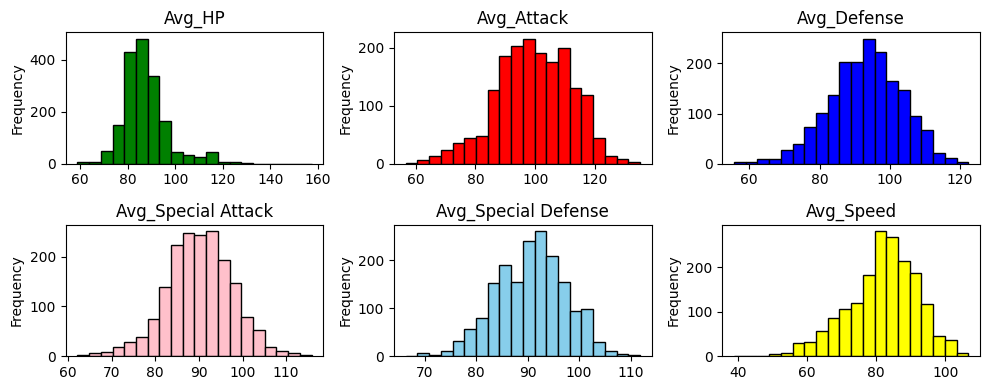

In [121]:
fig, ax = plt.subplots(2, 3, figsize=(10, 4))

ax[0,0].hist(showdown_df['Avg_HP'].dropna(),bins=20, color='green', edgecolor='black')
ax[0,0].set_title('Avg_HP')
ax[0,0].set_ylabel('Frequency')

ax[0,1].hist(showdown_df['Avg_Attack'].dropna(),bins=20, color='red', edgecolor='black')
ax[0,1].set_title('Avg_Attack')
ax[0,1].set_ylabel('Frequency')

ax[0,2].hist(showdown_df['Avg_Defense'].dropna(),bins=20, color='blue', edgecolor='black')
ax[0,2].set_title('Avg_Defense')
ax[0,2].set_ylabel('Frequency')

ax[1,0].hist(showdown_df['Avg_Special Attack'].dropna(),bins=20, color='pink', edgecolor='black')
ax[1,0].set_title('Avg_Special Attack')
ax[1,0].set_ylabel('Frequency')

ax[1,1].hist(showdown_df['Avg_Special Defense'].dropna(),bins=20, color='skyblue', edgecolor='black')
ax[1,1].set_title('Avg_Special Defense')
ax[1,1].set_ylabel('Frequency')

ax[1,2].hist(showdown_df['Avg_Speed'].dropna(),bins=20, color='yellow', edgecolor='black')
ax[1,2].set_title('Avg_Speed')
ax[1,2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

All the distributions for each Pokemon stat follow kind of a normal distribution, although a dip in the middle can be seen in the distribution of special defense.

Outliers are also prevalent in the dataset, especially in the average HP of a team. This can be better observed using a box plot shown below.

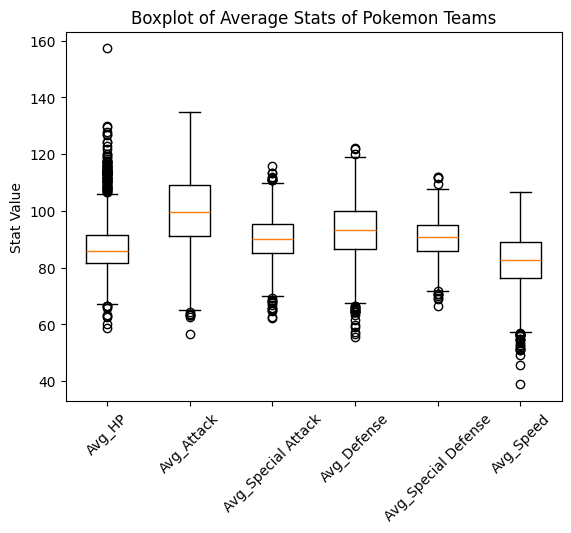

In [122]:
plots = ['Avg_HP', 'Avg_Attack', 'Avg_Special Attack', 'Avg_Defense', 'Avg_Special Defense', 'Avg_Speed']

plt.boxplot([showdown_df[plot].dropna() for plot in plots], tick_labels=plots)
plt.title("Boxplot of Average Stats of Pokemon Teams")
plt.xticks(rotation=45)
plt.ylabel("Stat Value")
plt.show()

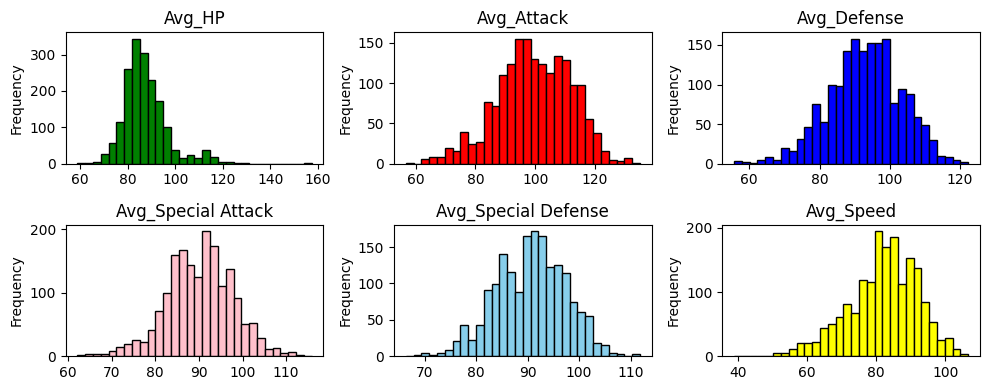

In [123]:
fig, ax = plt.subplots(2, 3, figsize=(10, 4))

ax[0,0].hist(showdown_df['Avg_HP'],bins=30, color='green', edgecolor='black')
ax[0,0].set_title('Avg_HP')
ax[0,0].set_ylabel('Frequency')

ax[0,1].hist(showdown_df['Avg_Attack'],bins=30, color='red', edgecolor='black')
ax[0,1].set_title('Avg_Attack')
ax[0,1].set_ylabel('Frequency')

ax[0,2].hist(showdown_df['Avg_Defense'],bins=30, color='blue', edgecolor='black')
ax[0,2].set_title('Avg_Defense')
ax[0,2].set_ylabel('Frequency')

ax[1,0].hist(showdown_df['Avg_Special Attack'],bins=30, color='pink', edgecolor='black')
ax[1,0].set_title('Avg_Special Attack')
ax[1,0].set_ylabel('Frequency')

ax[1,1].hist(showdown_df['Avg_Special Defense'],bins=30, color='skyblue', edgecolor='black')
ax[1,1].set_title('Avg_Special Defense')
ax[1,1].set_ylabel('Frequency')

ax[1,2].hist(showdown_df['Avg_Speed'],bins=30, color='yellow', edgecolor='black')
ax[1,2].set_title('Avg_Speed')
ax[1,2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Looking at the box plot, the average HP of Pokemon teams has the most severe outlier. On the other hand, the average attack has the biggest interquartile range and whiskers, showing a wide distribution of attack values of each team.

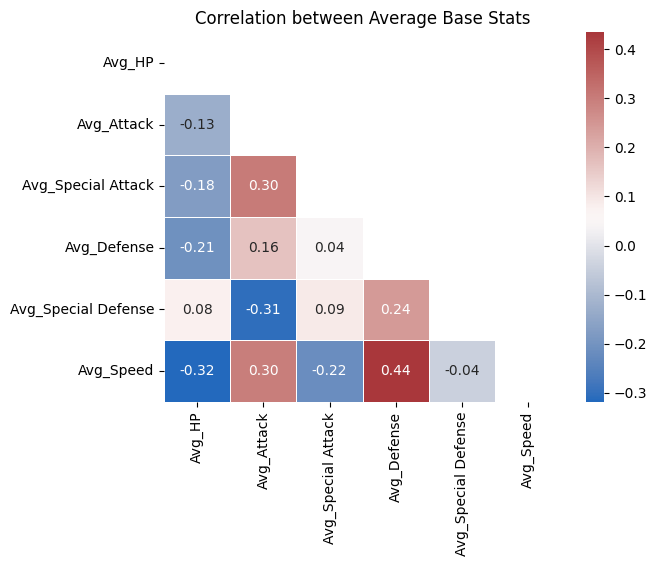

In [124]:
team_stats_df = showdown_df[
    [
        "Avg_HP",
        "Avg_Attack",
        "Avg_Special Attack",
        "Avg_Defense",
        "Avg_Special Defense",
        "Avg_Speed",
    ]
]
team_stats_correlation = team_stats_df.corr()
ax = sns.heatmap(
    team_stats_correlation,
    mask=np.triu(team_stats_correlation),
    annot=True,
    fmt = ".2f",
    linewidth=0.5,
    cmap="vlag"
)
plt.title("Correlation between Average Base Stats")
plt.show()

Based on the Pearson correlation of the average base stats of Pokemon teams, we can see that there is a moderate positive correlation between special attack and attack, speed and attack, and defense and speed.
From this, can infer that Pokemon with a high attack value can be expected to have a moderately high amount of special attack, and/or speed. What we did not expect is that Pokemon teams with high defense also have high speed.

Regarding the negative correlations, what we can see is that HP and speed have a moderately negative correlation, just like attack and special defense. This would make sense as that means teams with high HP would have a lower speed stat.
Pokemon teams with high attack also have a down side of lowered special defense.

### 4.2 Lead Pokemon

#### 4.2.1 Mode of Lead Pokemon

Another thing we would like to observe is which Pokemon is brought
out first. For this, we will use a bar graph and get the mode.

<Axes: xlabel='LeadPokemon'>

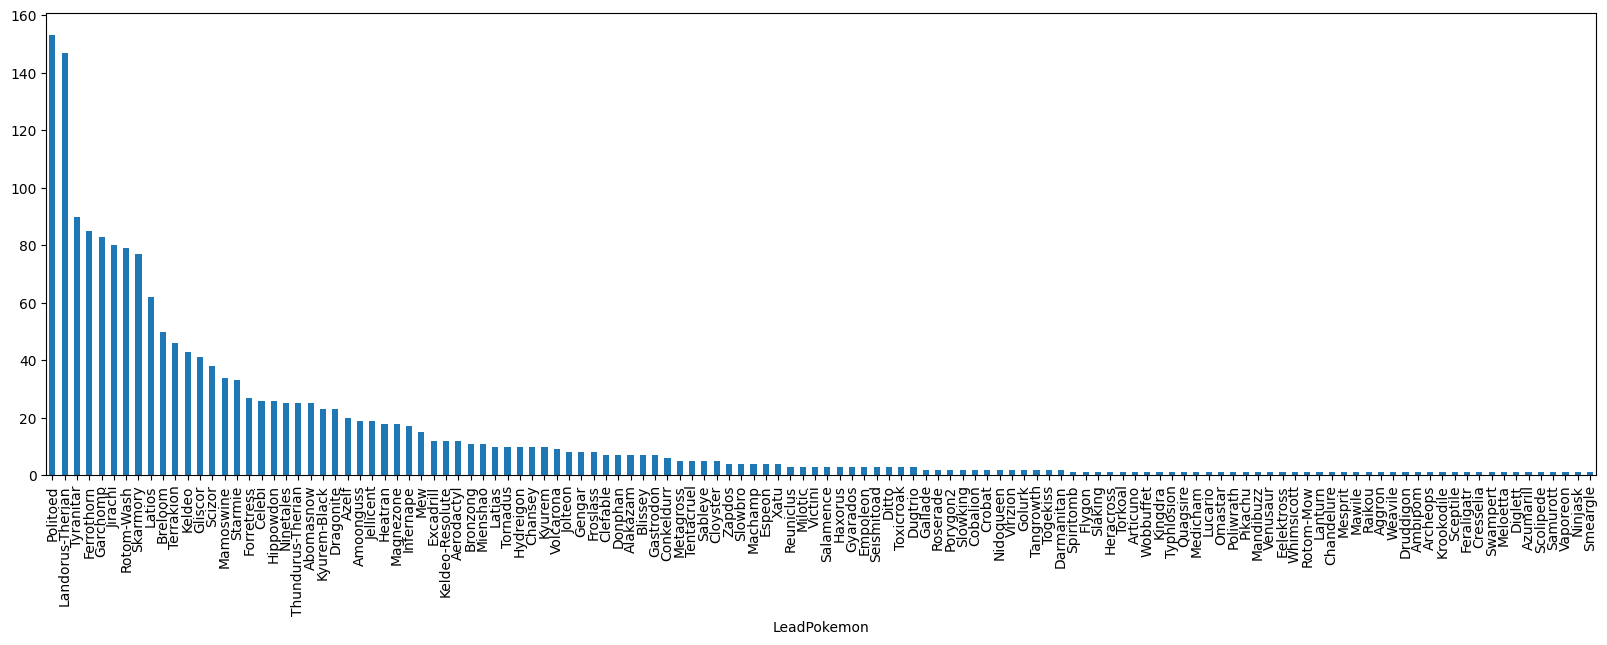

In [125]:
showdown_df["LeadPokemon"].value_counts()
showdown_df["LeadPokemon"].value_counts().plot(kind="bar", figsize=(20, 6))

In [126]:
showdown_df["LeadPokemon"].value_counts()

LeadPokemon
Politoed            153
Landorus-Therian    147
Tyranitar            90
Ferrothorn           85
Garchomp             83
                   ... 
Scolipede             1
Samurott              1
Vaporeon              1
Ninjask               1
Smeargle              1
Name: count, Length: 126, dtype: int64

As seen in the graph and the counts, most players choose to use Politoed
as their lead Pokemon, closely followed by Landorus-Therian, with the following
choices being at least 38.8% less frequently used.

#### 4.2.2 Lead Pokemon stat distribution

We also wanted to view the distribution of the stats
of each lead Pokemon in order to understand if the stats of a Pokemon
play a factor in why it is chosen as the lead.

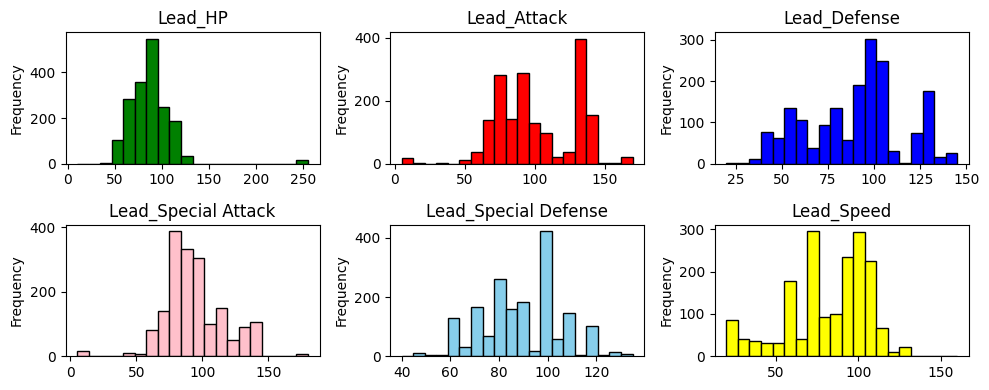

In [127]:
fig, ax = plt.subplots(2, 3, figsize=(10, 4))

ax[0,0].hist(showdown_df['Lead_HP'],bins=20, color='green', edgecolor='black')
ax[0,0].set_title('Lead_HP')
ax[0,0].set_ylabel('Frequency')

ax[0,1].hist(showdown_df['Lead_Attack'],bins=20, color='red', edgecolor='black')
ax[0,1].set_title('Lead_Attack')
ax[0,1].set_ylabel('Frequency')

ax[0,2].hist(showdown_df['Lead_Defense'],bins=20, color='blue', edgecolor='black')
ax[0,2].set_title('Lead_Defense')
ax[0,2].set_ylabel('Frequency')

ax[1,0].hist(showdown_df['Lead_Special Attack'],bins=20, color='pink', edgecolor='black')
ax[1,0].set_title('Lead_Special Attack')
ax[1,0].set_ylabel('Frequency')

ax[1,1].hist(showdown_df['Lead_Special Defense'],bins=20, color='skyblue', edgecolor='black')
ax[1,1].set_title('Lead_Special Defense')
ax[1,1].set_ylabel('Frequency')

ax[1,2].hist(showdown_df['Lead_Speed'],bins=20, color='yellow', edgecolor='black')
ax[1,2].set_title('Lead_Speed')
ax[1,2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Looking at the distribution of lead Pokemon stats, the values are more spread out. The HP stat is still the one with big outliers and we can view this better, including the different measures of dispersion.

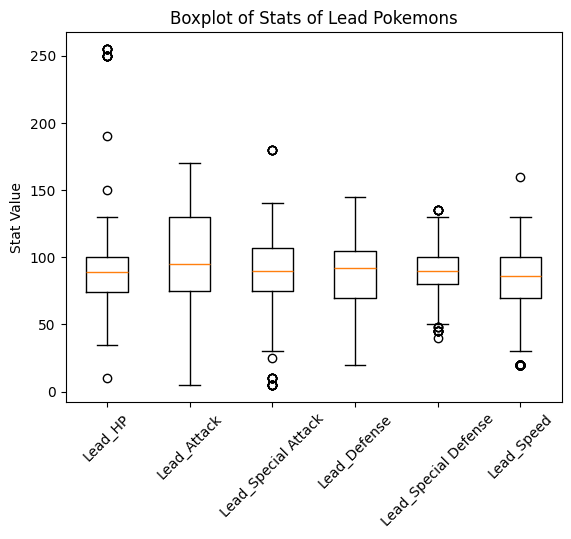

In [128]:
plots = ['Lead_HP', 'Lead_Attack', 'Lead_Special Attack', 'Lead_Defense', 'Lead_Special Defense', 'Lead_Speed']

plt.boxplot([showdown_df[plot].dropna() for plot in plots], tick_labels=plots)
plt.title("Boxplot of Stats of Lead Pokemons")
plt.xticks(rotation=45)
plt.ylabel("Stat Value")
plt.show()

As we can see, some Pokemon brought out as leads have an absurdly high amount of HP compared to the rest while Attack still has the biggest interquartile range.

### 4.3 Elo and Turncount

Another interesting set of statistics to explore is Elo and Turncount. Elo is
is the main ladder rating that dictates a player's position in the format. 
A higher ELO constitutes to a higher ranking in the ladder, and generally indicates a higher skill level. 
TurnCount on the other hand simply measures the amount of turns it took to finish the game.

#### 4.3.1 Mean and Median of Elo and Turn Count

In [129]:
elo_turncount_df = showdown_df[['Elo', 'TurnCount']]

In [130]:
elo_turncount_df.agg(['mean', 'median'])

,Elo,TurnCount
mean,1383.954749,29.005587
median,1368.000000,24.000000


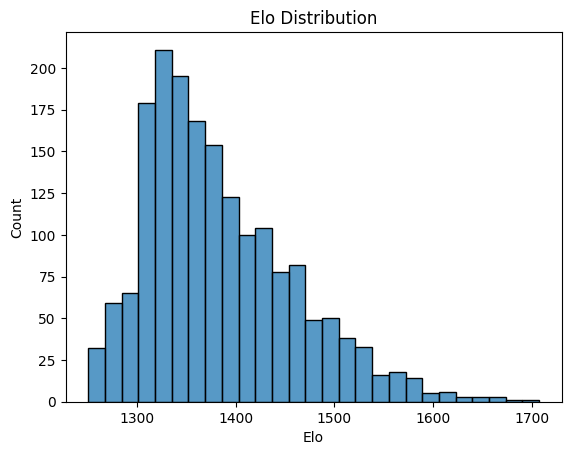

In [131]:
sns.histplot(elo_turncount_df['Elo'])
plt.title("Elo Distribution")
plt.show()

Based off the histogram, the elo distribution looks positively skewed.

But for a more quantifiable analysis, we conduct a Shapiro-Wilk test for normality.

* $H_0$: The data is normally distributed
* $H_a$: The data is not normally distributed

We set a significance level of $a = 0.05$.

In [132]:
statistic, p_value = sp.shapiro(elo_turncount_df['Elo'])

print(f"{p_value = }")

p_value = np.float64(6.169603471297848e-25)


With a p-value of around $4.06 \times 10^{-35} (< a = 0.05)$,
we reject $H_0$, i.e, elo is not normally distributed.

From the graph, ELO is right skewed because generally most players dont break 1400 ELO count and fewer players maintain a high ELO rating.

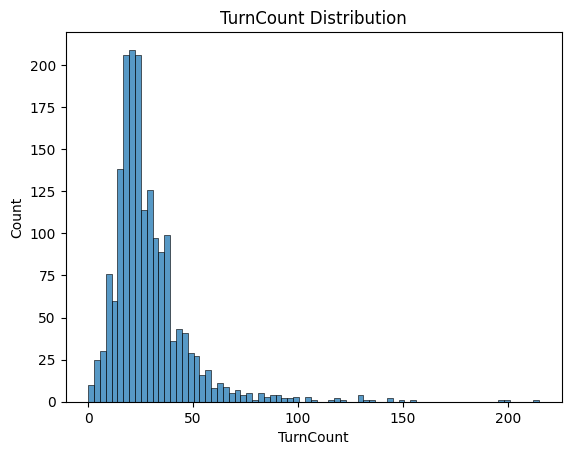

In [133]:
sns.histplot(elo_turncount_df['TurnCount'])
plt.title("TurnCount Distribution")
plt.show()

The turncount distribution appears positively skewed as well;
we again conduct a test for normality:

In [134]:
statistic, p_value = sp.shapiro(elo_turncount_df['TurnCount'])
print(f"{p_value = }")

p_value = np.float64(1.3193500384896357e-45)


With a p-value of around $1.55 \times 10^{-64} (< a = 0.05)$, we
reject $H_0$, i.e, turncount is not normally distributed.

Most games observed run normally between 0 and 50 turns, but there are extreme cases where one of the players run a stall team prolonging the game. A stall team is a team that aims to outlive the opponent by healing though damage, inflicting status conditions like paralysis and by lowering the stats of opposing pokemon.

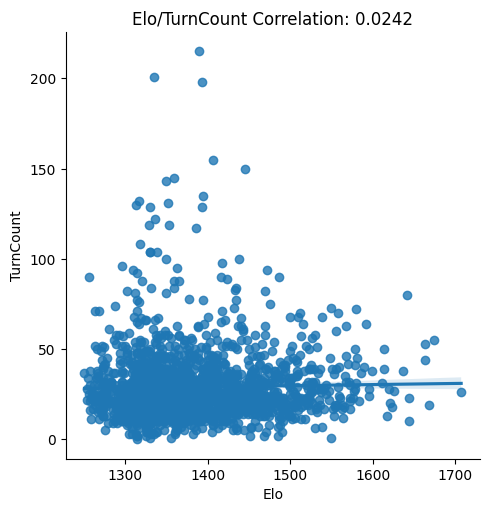

In [135]:
corr = elo_turncount_df.corr()['Elo']['TurnCount']
ax = sns.lmplot(x='Elo', y='TurnCount', data=elo_turncount_df)
plt.title(f"Elo/TurnCount Correlation: {corr:.4f}")
plt.show()

It would appear that there is very little correlation between elo and turncount. This proves that games within high ELO's are not guarranteed to be longer or shorter.

### 4.4 Pokemon Types

As mentioned pokemon typing is crucial in building teams, as such an intriguing detail to look into is the frequency of inclusions of a pokemon type to a type to see if a type would be more dominant in teambuilding than others



#### 4.4.1 Total matches

A new data frame is instantiated for the purposes of this section, that which would contain the total matches, and the sum of all wins, loses and ties for each type.

In [136]:
types = ['Normal', 'Fighting','Flying','Poison','Ground','Rock','Bug','Ghost','Steel',
         'Fire','Water','Grass','Electric','Psychic','Ice','Dragon','Dark'
]

results = ['win', 'lose', 'tie', 'total']

gen5_type_winrate_df = pd.DataFrame({'Type': types})
for result in results:
    gen5_type_winrate_df[result] = 0
    
gen5_type_winrate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Type    17 non-null     object
 1   win     17 non-null     int64 
 2   lose    17 non-null     int64 
 3   tie     17 non-null     int64 
 4   total   17 non-null     int64 
dtypes: int64(4), object(1)
memory usage: 812.0+ bytes


In [137]:
for row in showdown_df.itertuples():
    for type in types:
        if (showdown_df.at[row.Index, f'Has_{type}']):
            result = showdown_df.at[row.Index, 'Result']
            gen5_type_winrate_df.loc[gen5_type_winrate_df['Type'] == type, result] += 1
            gen5_type_winrate_df.loc[gen5_type_winrate_df['Type'] == type, 'total'] += 1

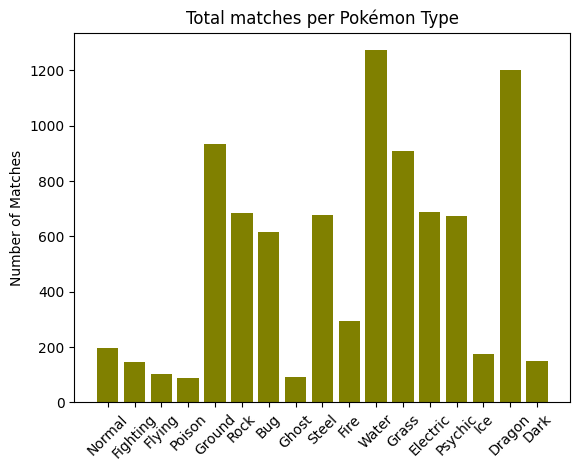

In [138]:
plt.bar(gen5_type_winrate_df['Type'], gen5_type_winrate_df['total'], color='olive')

plt.ylabel('Number of Matches')
plt.title('Total matches per Pokémon Type')
plt.xticks(rotation=45)
plt.show()

As seen in the bar plot above, the two types prefered to bring are Water and Dragon types.



#### 4.4.2 Win/Lose rate

For the following section, the sum of wins, loses and ties are utilized to form columns for the percentage of the results.

In [139]:
for row in gen5_type_winrate_df.itertuples():
    for result in results:
        wins = gen5_type_winrate_df.loc[row.Index, 'win']
        loses = gen5_type_winrate_df.loc[row.Index, 'lose']
        ties = gen5_type_winrate_df.loc[row.Index, 'tie']
        total = gen5_type_winrate_df.loc[row.Index, 'total']
        
        gen5_type_winrate_df.loc[row.Index, 'win%'] = wins / total * 100
        gen5_type_winrate_df.loc[row.Index, 'lose%'] = loses / total * 100
        gen5_type_winrate_df.loc[row.Index, 'tie%'] = ties / total * 100
        

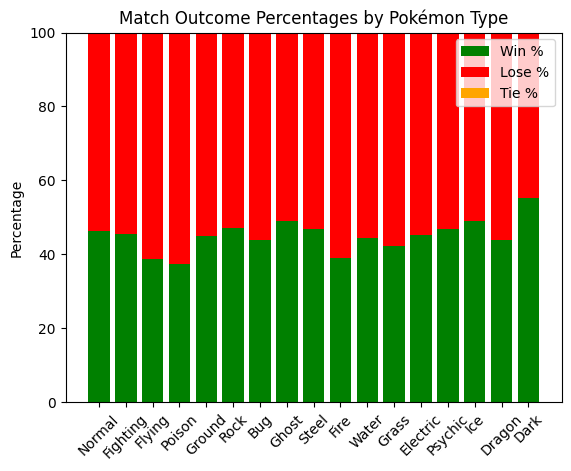

In [140]:
plt.bar(gen5_type_winrate_df['Type'], gen5_type_winrate_df['win%'], label='Win %', color='green')
plt.bar(gen5_type_winrate_df['Type'], gen5_type_winrate_df['lose%'], bottom=gen5_type_winrate_df['win%'], label='Lose %', color='red')
plt.bar(gen5_type_winrate_df['Type'], gen5_type_winrate_df['tie%'], bottom=gen5_type_winrate_df['win%'] + gen5_type_winrate_df['lose%'], label='Tie %', color='orange')

plt.ylabel('Percentage')
plt.title('Match Outcome Percentages by Pokémon Type')
plt.legend()
plt.xticks(rotation=45)
plt.show()

Observing the graph would give us the impression that all the Pokemon types are middling in win rate, with no specific type breaking the 60% win rate and merely staying below it.

## Chapter 5. Data Mining

### 5.1 Preparing the Dataset


The csv files are imported to dataframes. Specifically, the Showdown dataset will be used for data mining purposes, while the Pokemon Stats dataset is used to convert each Pokemon into an integer. That integer is the index of said Pokemon in the Pokemon Stats dataset. This is done to make one-hot-encoding easier.

The data mining also uses the cleaned up version of the Showdown dataset with no duplicate players to determine the meta based on the choices of multiple players.

In [141]:
pokemon_df = pd.read_csv('showdown.csv').loc[:, ['Pokemon 1','Pokemon 2','Pokemon 3','Pokemon 4','Pokemon 5','Pokemon 6']]
pokedex_df = pd.read_csv('dataset/bulbagarden/pokemon_gen5_stats.csv')
pokedex_df

,Pokedex number,Name,HP,Attack,Special Attack,Defense,Special Defense,Speed,Stat total,Stat average
0,1,Bulbasaur,45,49,49,65,65,45,318,53.00
1,2,Ivysaur,60,62,63,80,80,60,405,67.50
2,3,Venusaur,80,82,83,100,100,80,525,87.50
3,4,Charmander,39,52,43,60,50,65,309,51.50
4,5,Charmeleon,58,64,58,80,65,80,405,67.50
...,...,...,...,...,...,...,...,...,...,...
665,647,Keldeo,91,72,90,129,90,108,580,96.67
666,647,Keldeo-Resolute,91,72,90,129,90,108,580,96.67
667,648,Meloetta,100,77,77,128,128,90,600,100.00
668,648,Meloetta-Pirouette,100,128,90,77,77,128,600,100.00



Each Pokemon team in the Showdown dataset is converted to numerical baskets with each Pokemon being represented using their index number in the Pokedex data frame.

In [142]:
baskets = []
for index, row in pokemon_df.iterrows():
    pkmn = row
    pkmn = [int(pokedex_df[pokedex_df['Name']==x].index[0]) for x in pkmn]
    baskets.append(pkmn)

for i, basket in enumerate(baskets):
    print('Basket', i, basket)

Basket 0 [394, 285, 247, 606, 442, 592]
Basket 1 [247, 64, 380, 611, 661, 542]
Basket 2 [247, 604, 120, 64, 495, 226]
Basket 3 [247, 520, 204, 372, 477, 285]
Basket 4 [654, 185, 72, 50, 611, 384]
Basket 5 [247, 486, 611, 661, 64, 379]
Basket 6 [93, 148, 64, 459, 226, 211]
Basket 7 [459, 112, 185, 72, 226, 384]
Basket 8 [226, 427, 592, 247, 379, 495]
Basket 9 [506, 450, 37, 120, 2, 93]
Basket 10 [455, 611, 606, 380, 450, 211]
Basket 11 [450, 495, 611, 606, 134, 211]
Basket 12 [606, 211, 120, 495, 37, 661]
Basket 13 [450, 148, 285, 120, 650, 211]
Basket 14 [455, 611, 606, 380, 450, 211]
Basket 15 [185, 384, 663, 657, 231, 665]
Basket 16 [285, 64, 450, 483, 211, 665]
Basket 17 [37, 349, 473, 584, 450, 476]
Basket 18 [442, 606, 592, 285, 247, 323]
Basket 19 [64, 450, 427, 226, 247, 93]
Basket 20 [247, 64, 285, 648, 661, 211]
Basket 21 [112, 201, 90, 450, 148, 231]
Basket 22 [64, 648, 661, 611, 604, 247]
Basket 23 [380, 372, 606, 611, 236, 477]
Basket 24 [285, 380, 652, 247, 665, 211]
Baske

The baskets are then turned to a data frame of one-hot-encoded values. This is done since some algorithms require one-hot-encoding to work and is more efficient in general. Each row represents a team, and each column represent the pokemon. If an element of a row is `1`, then the pokemon exists within the team.

In [143]:
bool_df = pd.DataFrame([[0 for _ in range(670)] for _ in range(1790)], columns=[i for i in range(670)])

for i, basket in enumerate(baskets):
    bool_df.iloc[i, basket] = 1

bool_df

,0,1,2,3,4,5,6,7,8,9,...,660,661,662,663,664,665,666,667,668,669
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1785,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1786,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1787,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1788,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


This is a Helper Function to revert the Pokedex Index number to Pokemon Name for analysis.

In [144]:
def revert(list, key_df):
    return [key_df.loc[x,'Name'] for x in list]

### 5.2 Association Rule Mining


We perform association rule mining to identify relationships and associations within the dataset. Association Rule Mining works well with our dataset because we can treat team as a basket, where each pokemon is treated as in item of that basket. In particular, we want to further investigate how pokemon are being built together. Through this, we can see potential synergies and combinations of pokemon that are prevalent within the Gen 5 OU Metagame.

We first generate frequent itemsets with a support level of `20%` of the number of baskets.

In [145]:
team_count = len(bool_df)
support_percentage =  1790 * 0.2

rule_miner = RuleMiner(support_t= support_percentage, confidence_t=0)
frequent_itemsets = revert(rule_miner.get_frequent_itemsets(bool_df), pokedex_df)
print([x.to_list() for x in frequent_itemsets])

[['Politoed'], ['Scizor'], ['Tyranitar'], ['Latios'], ['Jirachi'], ['Garchomp'], ['Ferrothorn'], ['Landorus-Therian']]


We can see that we have a lot of frequent itemsets, although most of them are just singletons. We now will lower the support level to 10% and see what frequent itemsets appear.

In [146]:
support_percentage =  1790 * 0.1

rule_miner = RuleMiner(support_t= support_percentage, confidence_t=0)
frequent_itemsets = revert(rule_miner.get_frequent_itemsets(bool_df), pokedex_df)
print([x.to_list() for x in frequent_itemsets])

[['Tentacruel', 'Politoed'], ['Politoed', 'Ferrothorn'], ['Latios', 'Tyranitar'], ['Landorus-Therian', 'Tyranitar'], ['Ferrothorn', 'Latios'], ['Latios', 'Landorus-Therian']]


Given the list of frequent itemsets above, we can now investigate the rules that can be generated from them. Let us retain the support percentage and set our confidence interval to 50%.

In [147]:
support_percentage =  1790 * 0.1
confidence_interval = 0.5

rule_miner = RuleMiner(support_t= support_percentage, confidence_t=confidence_interval)
rules = rule_miner.get_association_rules(bool_df)

for rule in rules:
    print(f"{revert(rule[0], pokedex_df)} -> {revert(rule[1], pokedex_df)}")

['Tentacruel'] -> ['Politoed']
['Tentacruel'] -> ['Politoed']
['Politoed'] -> ['Ferrothorn']
['Ferrothorn'] -> ['Politoed']
['Ferrothorn'] -> ['Politoed']
['Politoed'] -> ['Ferrothorn']
['Landorus-Therian'] -> ['Tyranitar']
['Landorus-Therian'] -> ['Tyranitar']


From this, we extract the unique rules.

In [148]:
unique_rules = set([(tuple(x[0]), tuple(x[1])) for x in rules])

for rule in unique_rules:
    print(f"{revert(rule[0], pokedex_df)} -> {revert(rule[1], pokedex_df)}")

['Landorus-Therian'] -> ['Tyranitar']
['Politoed'] -> ['Ferrothorn']
['Tentacruel'] -> ['Politoed']
['Ferrothorn'] -> ['Politoed']


We can see that having a Landorus-Therian would generally assume that they would also have a Tyranitar, this is Tyranitar's Sand Stream ability being able to set up sand storm on entry is greatly beneficial for Landorus-Therian to boost it's Special Defense.

Another rule is Politoed -> Ferrothorn where Ferrothorn covers Politoeds weaknesses, Electric and Grass type, due to its steel and grass typing allowing it to have a 4 times resistance to these.

Politoed is also assumed to be present when there is a Tentacruel this is because of Tentacruel's Rain Dish ability heling 1/16th of its HP each turn, that would otherwise be wasted if not utilized im the rain.

Lastly, Politoed is also thought to come with Ferrothorn for the same reason Ferrothorn is assumed with Politoed since Politoed is a safe switch in for fire type moves dampening its effect with the rain and the natural special bulk of Politoed allows it to resist more on top of the 2x resistance that comes from its water typing.

### 5.3 Clustering through DBSCAN with Jaccard Distance

We now investigate further the general teams and archetypes through clustering. Similar to Association Rule Mining, we will treat each datapoint representing the pokemon of each team.

Given the nature of our dataset, we note two important things:

1. **Competitive Pokemon is *noisy* and so is our dataset**

    There are plenty of datapoints which do not fit well within groups. Even with regards to a strict metagame, people have the freedom to build however they please. Clustering through K-medoids indicate a low silhouette score for many choices of **k**. (See Appendix)

    We are also not sure of the "shape" of the clusters themselves whether it is irregular or not, nor do we have a good idea of the number of clusters to expect.

    **Given this consideration, we use DBSCAN and cluster based on density.**

2. **We need to consider metrics to determine how *different* each team is from one another**

    We cannot use euclidean metrics since we represent each datapoint as a set, and we need to use a measure that is appropriate to this type of data.

    **Given this consideration, we use Jaccard Distance. to determine similarity/difference**

From our `bool_df` used earlier, we convert it into a NumPy array and prepare a distance matrix based on jaccard distance.

In [149]:
array_of_teams = bool_df.to_numpy()

distmatrix = spsd.squareform(spsd.pdist(array_of_teams, metric='jaccard'))

For the parameters for DBSCAN we consider the following values for epsilon and the minimum number of samples/points.

1. **Epsilon**

    Epsilon is radius considered in the calculation for the classification of points. It is the maximum distance for two points to be considered as neighbors within a cluster.

    Our choice of epsilon is based on the following:

    Jaccard distance is calculated through the formula: 

    $$D(P, Q)= 1 - \frac{|P \cap Q|}{|P \cup Q|} $$

    Since each data point is has a cardinality of 6 (where each team has 6 pokemon) we can already see the possible distances:

    1 similar = 0.90909090909
    
    2 similar = 0.8

    3 similar = 0.666

    4 similar = 0.5

    5 similar = 0.286

    all similar = 0

    Based on this, we will choose a starting epsilon of `0.3`, so initial clusters will need to have 5 similar pokemon. This will help us ensure that 
    each group be fitted

    We set the minimum number of points to be `25` in order for point to emphasize the density of our clusters. This will also help us lower the noise of compositions that don't classify well.

In [150]:
db = DBSCAN(eps=0.3 , min_samples=25, metric='precomputed')
labels = db.fit_predict(distmatrix)

print("Cluster labels:", labels)

for label in set(labels):
    print(f"{label} Count: {np.sum(labels == label)}")


Cluster labels: [-1  0 -1 ... -1 -1 -1]
0 Count: 130
1 Count: 70
2 Count: 142
3 Count: 74
-1 Count: 1374


Lets take a look at each some of the pokemon in each cluster (we take a look at 5 pokemon from each cluster) as well as the frequencies of pokemon in each cluster.

In [151]:
clusters_indices = set(labels)

clusters = []

for x in range((len(clusters_indices) - 1)):
    clusters.append([])
    teams = []
    for index, label in enumerate(labels):
        if label == x:
            clusters[x].append(revert(baskets[index], pokedex_df))

In [152]:
def count_frequencies(teams):
    counts = {}
    total = len(teams)

    for team in teams:
        for pokemon in team:
            if pokemon not in counts.keys():
                counts.update({pokemon: 1})
            else:
                counts[pokemon] += 1
    
    for pokemon in counts:
        counts[pokemon] = (counts[pokemon] / total) * 100
    
    counts = sorted(counts.items(), key=lambda x:x[1], reverse=True)
    
    return counts


In [153]:
cluster_frequencies = []
for x in range((len(clusters_indices) - 1)):
    cluster_frequencies.append(count_frequencies(clusters[x])) 

In [154]:
print("Cluster 0")

for team in clusters[0][0:5]:
    print(team)

print("----Top 10 Frequencies----")

for pokemon, frequency in cluster_frequencies[0][0:10]:
        print(f"{pokemon}: {round(frequency, 2)}%")


Cluster 0
['Tyranitar', 'Alakazam', 'Latios', 'Ferrothorn', 'Landorus-Therian', 'Excadrill']
['Tyranitar', 'Rotom-Wash', 'Ferrothorn', 'Landorus-Therian', 'Alakazam', 'Latias']
['Landorus-Therian', 'Jirachi', 'Latios', 'Rotom-Wash', 'Tyranitar', 'Ferrothorn']
['Tyranitar', 'Landorus-Therian', 'Garchomp', 'Latios', 'Jirachi', 'Kingdra']
['Tyranitar', 'Rotom-Wash', 'Excadrill', 'Landorus-Therian', 'Alakazam', 'Ferrothorn']
----Top 10 Frequencies----
Tyranitar: 96.92%
Landorus-Therian: 90.0%
Latios: 83.85%
Ferrothorn: 66.15%
Alakazam: 45.38%
Rotom-Wash: 40.0%
Keldeo: 34.62%
Garchomp: 33.08%
Jirachi: 24.62%
Excadrill: 22.31%


<p align="center">
<a href="https://pokemondb.net/pokedex/tyranitar"><img src="https://img.pokemondb.net/sprites/black-white/anim/normal/tyranitar.gif" alt="Magnezone" style="width: 120px;"></a>
</p>
In this cluster, we can see the prevalence of Tyranitar, Landorus-Therian, Alakazam and many others. This can be interpreted as the foundations of a sandstorm based team, as Tyranitar would be setting up sandstorm and pokemon such as Landorus-Therian, Garchomp and Excadrill benefit from a boosted Special Defense under sandstorm. Ferrothorn, Jirachi, and Alakazam however are also popular picks as they do not have the drawback of taking damage under the sandstorm. The rest would serve to be generally useful pokemon under any situation like Latios having strong threatening Draco Meteors, and Keldeo with the chance of carrying choice specs with Hydro pump. 

In [155]:
print("Cluster 1")

for team in clusters[1][0:5]:
    print(team)

print("----Top 10 Frequencies----")

for pokemon, frequency in cluster_frequencies[1][0:10]:
        print(f"{pokemon}: {round(frequency, 2)}%")


Cluster 1
['Garchomp', 'Dragonite', 'Breloom', 'Starmie', 'Volcarona', 'Scizor']
['Garchomp', 'Breloom', 'Volcarona', 'Dragonite', 'Starmie', 'Scizor']
['Dragonite', 'Breloom', 'Volcarona', 'Mamoswine', 'Starmie', 'Scizor']
['Jirachi', 'Garchomp', 'Starmie', 'Terrakion', 'Breloom', 'Dragonite']
['Garchomp', 'Starmie', 'Volcarona', 'Celebi', 'Salamence', 'Scizor']
----Top 10 Frequencies----
Starmie: 100.0%
Garchomp: 94.29%
Dragonite: 92.86%
Volcarona: 80.0%
Scizor: 74.29%
Breloom: 68.57%
Jirachi: 20.0%
Terrakion: 15.71%
Lucario: 5.71%
Azelf: 5.71%


<p align="center">
<a href="https://pokemondb.net/pokedex/starmie"><img src="https://img.pokemondb.net/sprites/black-white/anim/normal/starmie.gif" alt="Magnezone" style="width: 120px;"></a>
</p>
This cluster closely ressembles that of a "Smurf" structure, wherein most if not all of the pokemon in the team have the capability to set up and be sweepers. Garchomp and Dragonite are extremely powerful with the combination of Swords Dance and Outrage capable of knocking out most non-steel type pokemon. Volcarona and Starmie on the other hand, are fast special sweepers sporting Quiver Dance for Volcarona and high Special Attadck and Speed for Starmie. Scizor and Breloom thrive with Swords Dance and the ability Technician boosting Bullet Punch and Mach Punch which are also priority moves. 

In [156]:
print("Cluster 2")

for team in clusters[2][0:5]:
    print(team)

print("----Top 10 Frequencies----")

for pokemon, frequency in cluster_frequencies[2][0:10]:
        print(f"{pokemon}: {round(frequency, 2)}%")

Cluster 2
['Scizor', 'Tentacruel', 'Politoed', 'Volcarona', 'Ferrothorn', 'Latios']
['Scizor', 'Politoed', 'Tentacruel', 'Thundurus-Therian', 'Ferrothorn', 'Latios']
['Politoed', 'Tentacruel', 'Ferrothorn', 'Keldeo-Resolute', 'Thundurus-Therian', 'Latios']
['Politoed', 'Thundurus-Therian', 'Landorus-Therian', 'Ferrothorn', 'Tentacruel', 'Tornadus']
['Politoed', 'Jirachi', 'Ferrothorn', 'Tentacruel', 'Latios', 'Thundurus-Therian']
----Top 10 Frequencies----
Politoed: 100.0%
Ferrothorn: 92.25%
Tentacruel: 71.13%
Thundurus-Therian: 66.9%
Latios: 64.08%
Keldeo: 43.66%
Starmie: 23.94%
Jirachi: 20.42%
Keldeo-Resolute: 17.61%
Tornadus: 15.49%


In [157]:
print("Cluster 3")

for team in clusters[3][0:5]:
    print(team)

print("----Top 10 Frequencies----")

for pokemon, frequency in cluster_frequencies[3][0:10]:
        print(f"{pokemon}: {round(frequency, 2)}%")

Cluster 3
['Garchomp', 'Dragonite', 'Magnezone', 'Latios', 'Scizor', 'Starmie']
['Dragonite', 'Magnezone', 'Jirachi', 'Latios', 'Kyurem-Black', 'Excadrill']
['Magnezone', 'Jirachi', 'Dragonite', 'Garchomp', 'Latios', 'Salamence']
['Latios', 'Garchomp', 'Reuniclus', 'Magnezone', 'Jirachi', 'Latias']
['Jirachi', 'Kyurem-Black', 'Latios', 'Magnezone', 'Dragonite', 'Garchomp']
----Top 10 Frequencies----
Magnezone: 90.54%
Garchomp: 87.84%
Kyurem-Black: 82.43%
Latios: 81.08%
Jirachi: 75.68%
Dragonite: 54.05%
Salamence: 29.73%
Starmie: 28.38%
Reuniclus: 12.16%
Landorus-Therian: 9.46%


<p align="center">
<a href="https://pokemondb.net/pokedex/magnezone"><img src="https://img.pokemondb.net/sprites/black-white/anim/normal/magnezone.gif" alt="Magnezone" style="width: 120px;"></a>
</p>

Lastly this cluster is what many would consider to be "DragMag", an archetype consisting of two or more dragon types and Magnezone. The strategy for this team usually follows that Magnezone would be there to trap and eliminate the steel type pokemon of the opposing team allowing the dragon types to safely execute sweeping tactics. Garchomp, Kyurem-Black, Salamence and Dragonite all sport really high attack and speed especially paired with Dragon Dance boosting both of these stats, once the enemy team does not have a steel type pokemon, all of these physical sweepers would have no trouble clearing the enemy team. Some of the other filler additions are included because they are generally good pokemon for any matchup encountered, such as Latios, Starmie and Landorus-Therian having good offense and coverage.

## Chapter 6. Statistical Inference

### 6.1 Usage of Pokemon by players at different Elo ratings


In this test we aim to determine if the pokemon usage of each ELO range group is different from one another. This is to determine if the teambuilding strategies differ when a player is just starting off, has a moderate level of experience, or is a really skilled player. 

The ELO ranges differ for different formats of competitive pokemon. For example, in the latest OU format, Generation 9, what is generally considered a high skill ELo is from the ranges of 1900 to 2000. In Generation 5 OU however, what is considered to be high skill is from more or less 1500 to 1700 or 2000 since the population of players is less, the format generally caps at 1700. For the sake of this test however, we will consider for those that are above 1700 since it is not outside the realm of possibility.

The groups chosen is as follows:
- 1000-1290
- 1291-1390
- 1391-1490
- 1491-2000

This is to mimic the usual 4 tiers of smogon uses which are 1000, 1530, 1630, and 1730 but is compressed since the afforementioned lower player population results to an ELO ceiling closer to 1700.

#### 6.1.1 Pre-processing

Before any processing, we first build a dataframe containing the groups of ELO as columns each with their raw and percentage values with the pokemon as the rows. 

In [ ]:
usage_elo_df = unique_pokemons_df
elo_ranges = ["1000-1290", "1291-1390", "1391-1490", "1491-2000"]

for elo_range in elo_ranges:
    usage_elo_df[elo_range + " raw"] = 0
    usage_elo_df[elo_range + " percent"] = 0
usage_elo_df

,pokemon,1000-1290 raw,1000-1290 percent,1291-1390 raw,1291-1390 percent,1391-1490 raw,1391-1490 percent,1491-2000 raw,1491-2000 percent
0,Amoonguss,0,0,0,0,0,0,0,0
1,Sableye,0,0,0,0,0,0,0,0
2,Sawsbuck,0,0,0,0,0,0,0,0
3,Honchkrow,0,0,0,0,0,0,0,0
4,Ferrothorn,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
199,Electrode,0,0,0,0,0,0,0,0
200,Nidoqueen,0,0,0,0,0,0,0,0
201,Sigilyph,0,0,0,0,0,0,0,0
202,Umbreon,0,0,0,0,0,0,0,0


After the setup, we will then now get the usage rating of each pokemon by going through every team in the `showdown_df` dataframe containing the scraped teams from Gen 5 OU. Iterating over each pokemon in each team revealed the raw counts of the pokemon's usage.

In [ ]:
for row in showdown_df.itertuples():
    elo = showdown_df.at[row.Index, "Elo"]
    
    elo_range = ""
    if elo > 1490:
        elo_range = "1491-2000"
    elif elo > 1390:
        elo_range = "1391-1490"
    elif elo > 1290:
        elo_range = "1291-1390"
    else:
        elo_range = "1000-1290"
        
        
    for i in range(1, 7):
        pkmn_name = showdown_df.loc[row.Index, f"Pokemon {i}"]
        usage_elo_df.loc[usage_elo_df["pokemon"] == pkmn_name, elo_range + " raw"] += 1
usage_elo_df

,pokemon,1000-1290 raw,1000-1290 percent,1291-1390 raw,1291-1390 percent,1391-1490 raw,1391-1490 percent,1491-2000 raw,1491-2000 percent
0,Amoonguss,3,0,41,0,25,0,17,0
1,Sableye,2,0,5,0,8,0,0,0
2,Sawsbuck,0,0,0,0,1,0,0,0
3,Honchkrow,1,0,2,0,3,0,0,0
4,Ferrothorn,25,0,287,0,160,0,50,0
...,...,...,...,...,...,...,...,...,...
199,Electrode,0,0,1,0,0,0,0,0
200,Nidoqueen,0,0,2,0,0,0,0,0
201,Sigilyph,0,0,5,0,0,0,1,0
202,Umbreon,2,0,5,0,2,0,0,0


After that, the percentages are solved in the `{elo_range} percent` column.

In [ ]:
for elo_range in elo_ranges:
    total = usage_elo_df[elo_range + " raw"].sum()
    usage_elo_df[elo_range + " percent"] = usage_elo_df[elo_range + " raw"] / total * 100
usage_elo_df

,pokemon,1000-1290 raw,1000-1290 percent,1291-1390 raw,1291-1390 percent,1391-1490 raw,1391-1490 percent,1491-2000 raw,1491-2000 percent
0,Amoonguss,3,0.454545,41,0.694444,25,0.805932,17,1.582868
1,Sableye,2,0.303030,5,0.084688,8,0.257898,0,0.000000
2,Sawsbuck,0,0.000000,0,0.000000,1,0.032237,0,0.000000
3,Honchkrow,1,0.151515,2,0.033875,3,0.096712,0,0.000000
4,Ferrothorn,25,3.787879,287,4.861111,160,5.157963,50,4.655493
...,...,...,...,...,...,...,...,...,...
199,Electrode,0,0.000000,1,0.016938,0,0.000000,0,0.000000
200,Nidoqueen,0,0.000000,2,0.033875,0,0.000000,0,0.000000
201,Sigilyph,0,0.000000,5,0.084688,0,0.000000,1,0.093110
202,Umbreon,2,0.303030,5,0.084688,2,0.064475,0,0.000000


#### 6.1.2 Identifying the Statistical Test

To identify which multiple means test is appropriate, a Shapiro-Wilks test would be done to identify if the groups are normally distributed or not while the levene's test will be done to see if the variances of our groups are the same. Knowing if our sample is normally distributed and have equal variances will help us decide in which test we would do whether it would be parametric or not.


##### 6.1.2.1 Shapiro-Wilks and Q-Q plot

The Shapiro Wilks Test of Normality is a test that determines if a given list of values is normally distributed or not, in this case it would be the usage rating of our ELO groups. 

The hypothesis is as follows:
* $H_0$: The data is normally distributed
* $H_a$: The data is not normally distributed

We set a significance level of $a = 0.05$. As such, we will reject the null hypothesis if the $p$ value reaches below this threshold.

Additionally, a Q-Q Plot is done to visualize if the groups showcase a normal distribution or not.

Shapiro-Wilk test 1000-1290: stat=0.5600170552018435, p=1.8970652961682416e-22
Reject H0: The group is likely not normal


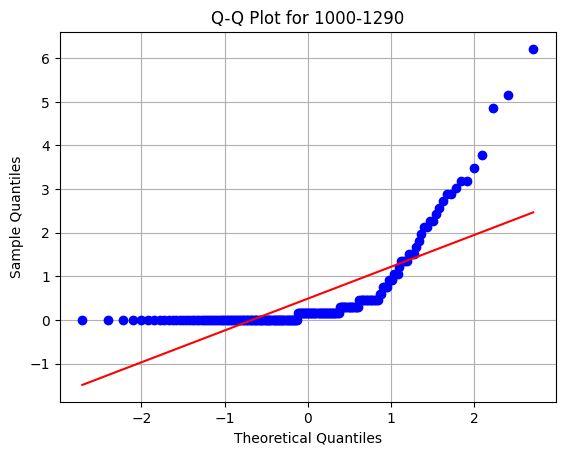

Shapiro-Wilk test 1291-1390: stat=0.5379253711143102, p=6.254748790470104e-23
Reject H0: The group is likely not normal


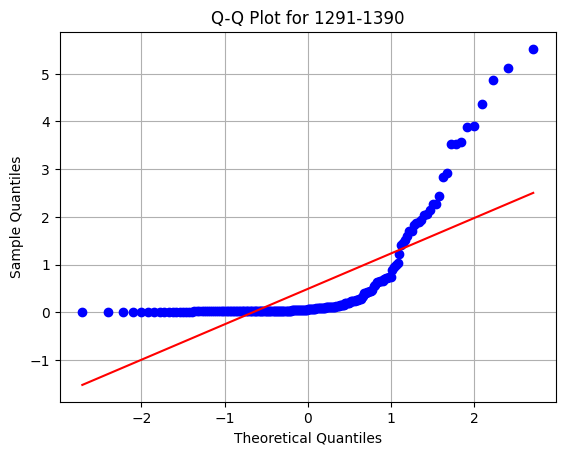

Shapiro-Wilk test 1391-1490: stat=0.5273620837701019, p=3.7328310262572893e-23
Reject H0: The group is likely not normal


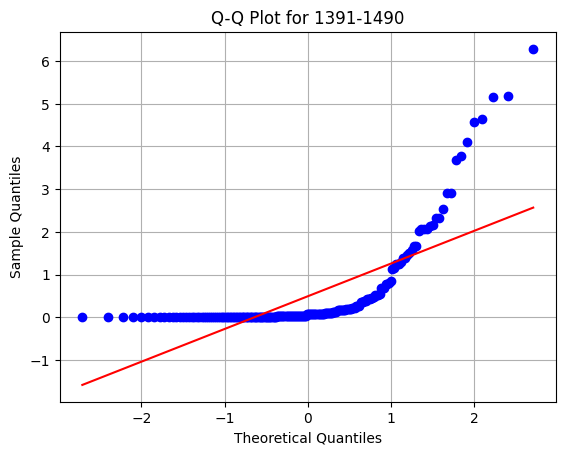

Shapiro-Wilk test 1491-2000: stat=0.5138679525923513, p=1.9553226049823525e-23
Reject H0: The group is likely not normal


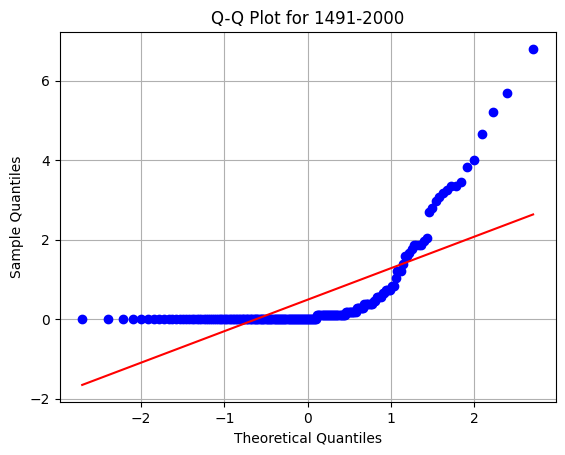

In [ ]:
for elo_range in elo_ranges:
    data = usage_elo_df[f"{elo_range} percent"]
    
    # Ben Shapiro
    stat, p = sp.shapiro(data)
    print(f"Shapiro-Wilk test {elo_range}: stat={stat}, p={p}")
    if p > 0.05:
        print("Accept H0: The group is likely normal")
    else:
        print("Reject H0: The group is likely not normal")
        
    # Q-Q plot
    sp.probplot(data, dist="norm", plot=plt)
    plt.title(f"Q-Q Plot for {elo_range}")
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Sample Quantiles")
    plt.grid(True)
    plt.show()

As seen in the Shapiro-Wilks test and Q-Q plot, the groups are all not normally distributed, which will make the Analysis of Variance less robust or less applicable.

##### 6.1.2.2 Levene's Test

Levene's test is used to assess the homogeneity of variances (also known as homoscedasticity) across groups, in this case, the groups would be the different ELO ranges. This is commonly used before conducting an ANOVA, as it is one of it's requirements.

The Hypothesis are as follows
- **Null hypothesis $H_{0}$**: All group variances are equal. $ H_{0}: \sigma_1^2 = \sigma_2^2 = \cdots = \sigma_k^2 $

- **Alternative hypothesis $H_{a}$**: At least one group has a different variance. $ H_{a}: \exists \, i, j \text{ such that } \sigma_i^2 \ne \sigma_j^2 $

In [ ]:
usage_percent_elo = []
for elo_range in elo_ranges:
    usage_percent_elo.append(usage_elo_df[f"{elo_range} percent"])

stat, p = sp.levene(usage_percent_elo[0], usage_percent_elo[1], usage_percent_elo[2], usage_percent_elo[3])
print(f"Levene's test: stat={stat}, p={p}")
if p > 0.05:
    print("Accept H0: The groups likely have equal variances")
else:
    print("Reject H0: The groups likely do not have equal variances")

Levene's test: stat=0.01791569872172893, p=0.9967361166053423
Accept H0: The groups likely have equal variances


As seen from the results of the Levene's test, the usage percentages of the pokemon in the groups are likely to have the same variances of that from the other groups.

#### 6.1.3 Kruskal-Wallis H Test

The Kruskal-Wallis H-test is a non-parametric alternative to one-way ANOVA according to Kruskal Wallis himself in his journal "Use of ranks in one-criterion variance analysis". We will be utilizing this since one of the factors that ANOVA relied on, the data being normally distributed, is not present within the data.

Solving for it would require to combine all data to be ranked from smallest to largest, then computing for the sum of ranks ($R_i$) for each group $i$. And then all plugged into the formula:

$\begin{align}
H = \frac{12}{N(N+1)} \sum_{i=1}^{k} \frac{R_i^2}{n_i} - 3(N+1)
\end{align}$

Where:
- $ H $ = Kruskal-Wallis test statistic  
- $ N $ = total number of observations  
- $ k $ = number of groups  
- $ R_i $ = sum of ranks for group $ i $  
- $ n_i $ = number of observations in group $ i $

The hypothesis is as follows:

> **Null hypothesis $H_{0}$**
- All group medians are equal. The distributions are identical across groups

> **Alternative hypothesis $H_{a}$**
- At least one group differs in distribution. One or more group's median differ from the others.

The function `kruskal()` exists under `scipy.stats` and will be utilized to solve for the p-value.

In [ ]:
stat, p = sp.kruskal(usage_percent_elo[0], usage_percent_elo[1], usage_percent_elo[2], usage_percent_elo[3])
print(f"Kruskal's test: stat={stat}, p={p}")
if p > 0.05:
    print("Accept H0: The groups likely have equal medians")
else:
    print("Reject H0: The groups likely do not have equal medians")

Kruskal's test: stat=19.658833296264717, p=0.00019974100624276498
Reject H0: The groups likely do not have equal medians


From the result of the Kruskal-Wallis H-test, we reject the null hypothesis meaning at least one group differs from one other group. To identify which group this is, we would need to do a post-hoc test akin to a Tukey-Kramer test for ANOVA, but non-parametric in nature.

#### 6.1.4 Dunn's Test

Dunn’s test is a non-parametric post hoc test by Olive Jean Dunn used after a significant Kruskal-Wallis test to identify which specific groups differ proposed in the journal "Multiple comparisons using rank sums". This test will determine which pairs of ELO groups are different.

The pairwise hypothesis is as follows:

- **Null hypothesis $H_{0}$**: The medians of the two groups are equal.

- **Alternative hypothesis $H_{a}$**: The medians of the two groups are different.

However, conducting a 0.05 significance test multiple times may introduce larger Type I error probability. With this in mind, a Bonferroni significance correction will be applied.

The Dunn's Test can be done through the module `scikit_posthocs` with the function `posthoc_dunn(data, correction)` which already includes what kind of correction would be done.

In [ ]:
import scikit_posthocs as scik

data = [usage_percent_elo[i] for i in range(4)]

p_values = scik.posthoc_dunn(data, p_adjust='bonferroni')

labels = ['1000-1290', '1291-1390', '1391-1490', '1491-2000']
p_values.columns = labels
p_values.index = labels

print(p_values)
print("")
print(p_values < 0.05)

           1000-1290  1291-1390  1391-1490  1491-2000
1000-1290   1.000000   0.114951   1.000000   0.220790
1291-1390   0.114951   1.000000   0.117831   0.000056
1391-1490   1.000000   0.117831   1.000000   0.215833
1491-2000   0.220790   0.000056   0.215833   1.000000

           1000-1290  1291-1390  1391-1490  1491-2000
1000-1290      False      False      False      False
1291-1390      False      False      False       True
1391-1490      False      False      False      False
1491-2000      False       True      False      False


With a 0.05 critical value and the results of the Dunn's test, we can see that only 1 pair seems to differ and that would be ELO range 1291-1390 and ELO range 1491-2000.

In [ ]:
for elo_range in elo_ranges:
    total = usage_elo_df[elo_range + " raw"].sum()
    print(f"{elo_range}: {total/6}")

1000-1290: 110.0
1291-1390: 984.0
1391-1490: 517.0
1491-2000: 179.0


<p align="center">
<a href="https://pokemondb.net/pokedex/pikachu"><img src="https://img.pokemondb.net/sprites/black-white/anim/normal/pikachu.gif" alt="Pikachu" style="width: 65px;"></a>
<a href="https://pokemondb.net/pokedex/pignite"><img src="https://img.pokemondb.net/sprites/black-white-2/anim/normal/pignite.gif" alt="Pignite" style="width: 80px;"></a>
<a href="https://pokemondb.net/pokedex/zoroark"><img src="https://img.pokemondb.net/sprites/black-white/anim/normal/zoroark.gif" alt="Zoroark"
style="width: 120px;"></a>
<a href="https://pokemondb.net/pokedex/reshiram"><img src="https://img.pokemondb.net/sprites/black-white/anim/normal/reshiram.gif" alt="Reshiram" style="width: 150px;"></a>
</p>

#### 6.1.5 Results and Discussion

The only pairwise inequality may be a byproduct of the 1291-1300 group having almost 6 times as much teams as 1491-2000. The inequal team distribution and the high team count within ELO range 1291-1300 may contribute to the emphasis of the difference between these two groups.

Assuming that the data set of ELO follows their skill level ie. no player is using a lower ELO account despite having a skill level, this result may indicate that the teambuilding within different ELO groups are mostly similar save for the ELO range of 1291 to 1300 and 1491 to 2000 insinuating that, the teambuilding of above beginner tiers of players differ with that of the teambuilding of high skilled players. 

### 6.2 Meta difference in 2015 and 2025


In this test, we aim to determine if there will be a difference in pokemon usage rates in Generation 5 OU between the year 2015 and the year 2025 comparing the first month of each. To do this, we will first be getting the differences of both data sets.

In [ ]:
gen5ou_usage_df

,Rank_2015,Pokemon,Usage%_2015,Raw_2015,%_2015,Real_2015,%.1_2015,Rank_2025,Usage%_2025,Raw_2025,%_2025,Real_2025,%.1_2025
0,62.0,Abomasnow,2.18801,81.0,2.188,72.0,2.478,37.0,3.97171,3409.0,3.972,2979.0,4.382
1,266.0,Abra,0.05402,2.0,0.054,2.0,0.069,NaN,NaN,NaN,NaN,NaN,NaN
2,173.0,Absol,0.24311,9.0,0.243,8.0,0.275,176.0,0.18641,160.0,0.186,130.0,0.191
3,291.0,Accelgor,0.05402,2.0,0.054,2.0,0.069,169.0,0.20855,179.0,0.209,149.0,0.219
4,74.0,Aerodactyl,1.70178,63.0,1.702,57.0,1.962,76.0,1.21050,1039.0,1.211,968.0,1.424
...,...,...,...,...,...,...,...,...,...,...,...,...,...
506,NaN,Zigzagoon,NaN,NaN,NaN,NaN,NaN,435.0,0.00233,2.0,0.002,1.0,0.001
507,82.0,Zoroark,1.43166,53.0,1.432,18.0,0.620,86.0,1.01361,870.0,1.014,289.0,0.425
508,256.0,Zorua,0.05402,2.0,0.054,0.0,0.000,434.0,0.00233,2.0,0.002,0.0,0.000
509,360.0,Zubat,0.02701,1.0,0.027,1.0,0.034,NaN,NaN,NaN,NaN,NaN,NaN


#### 6.2.1 Pre-processing

In building the dataframe, we begin with duplicating the generation 5 OU usage dataframe where the only relevant columns we keep is the pokemon name and usage for both the first month of 2015 and first month of 2025. We fill all NaN values with 0 because that indicates that that pokemon is not read in any of the battle log in that time frame for the tier. After which, a "Differences" column will be created.

In [ ]:
usage_diff = gen5ou_usage_df[["Pokemon", "Usage%_2015", "Usage%_2025"]].fillna(0)
usage_diff.loc[:, "Difference"] = usage_diff["Usage%_2025"] - usage_diff["Usage%_2015"]

In [ ]:
usage_diff["Difference"]

0      1.78370
1     -0.05402
2     -0.05670
3      0.15453
4     -0.49128
        ...   
506    0.00233
507   -0.41805
508   -0.05169
509   -0.02701
510    0.00117
Name: Difference, Length: 511, dtype: float64

#### 6.2.2 Initial Metagame Assumptions

The differences itself may hint to us towards some changes in meta albeit not concrete and backed it may still give us an idea on how the metagame shifted and how certain pokemon are favored over others.

In [ ]:
usage_diff.loc[usage_diff["Pokemon"].isin(["Venusaur", "Ninetales"])]


,Pokemon,Usage%_2015,Usage%_2025,Difference
303,Ninetales,6.15883,4.80124,-1.35759
471,Venusaur,4.97029,0.87497,-4.09532


<p align="center">
<a href="https://pokemondb.net/pokedex/venusaur"><img src="https://img.pokemondb.net/sprites/black-white/anim/normal/venusaur.gif" alt="Venusaur" style="width: 200px;"></a>
<a href="https://pokemondb.net/pokedex/ninetales"><img src="https://img.pokemondb.net/sprites/black-white/anim/normal/ninetales.gif" alt="Ninetales" style="width: 200px;"></a>
</p>
 One such would be Ninetails and Venusaur where both are staples of the Sun team however, see less play might be because of the metagame favoring the Sand and Rain weathers instead. It does not help that sun teams lack certain roles that other weather archetypes may contain such as checks against common threats like Latios.

In [ ]:
usage_diff.loc[usage_diff["Pokemon"].isin(["Excadrill", "Heatran"])]

,Pokemon,Usage%_2015,Usage%_2025,Difference
134,Excadrill,0.00000,18.02009,18.02009
191,Heatran,16.69368,9.44753,-7.24615


<p align="center">
<a href="https://pokemondb.net/pokedex/excadrill"><img src="https://img.pokemondb.net/sprites/black-white/anim/back-normal/excadrill.gif" alt="Excadrill" style="width: 200px;"></a>
<a href="https://pokemondb.net/pokedex/heatran"><img src="https://img.pokemondb.net/sprites/black-white/anim/normal/heatran.gif" alt="Heatran" style="width: 200px;"></a>
</p>

Excadrill's rise in usage may be attributed to the fact that the metagame shifted towards hazards(Stealth Rocks, Spikes, etc.) where Excadrill has access to a move Rapid Spin which controls and clears the hazards on the users side. It might also helped how the Sandstorm archetype might have been more fleshed in the passing of time since Excadrill benefits from the boosted Special Defense of Sandstorm. The might be an explanation to heatran's drop in usage, as it often used Air Balloon to fend off its 4x weakness to ground, hazards made it difficult for heatran to retain the balloon and would be easily picked off by ground type moves such as earthquake instantly fainting it.

In [ ]:
usage_diff.loc[usage_diff["Pokemon"].isin(["Dugtrio"])]


,Pokemon,Usage%_2015,Usage%_2025,Difference
113,Dugtrio,4.07888,0.07689,-4.00199


<p align="center">
<a href="https://pokemondb.net/pokedex/dugtrio"><img src="https://img.pokemondb.net/sprites/black-white/anim/normal/dugtrio.gif" alt="Dugtrio" style="width: 200px;"></a>
</p>
Dugtrio is an unusual case since Dugtrio is one of the few pokemon's where they experienced a Ban not from the pokemon itself but from a part of it, in this case it would be the ability Arena Trap. In 2018, following the Generation 7 OU ban of Arena Trap, Generation 4 5 and 6 OU also banned Arena Trap due to it creating unwinnable situations especially upon fainting the other team's weather setter in Generation 5 OU. Although not already seen too often only around 4%, the ban of arena trap made dugtrio almost vanish completely.

#### 6.2.3 Shapiro-Wilks

Before we proceed with testing, we first would like to discern if the differences in the usage rates of pokemons are normal. This would determine the paired observation test we would be performing. To do this, we create a temporary dataframe containing the usgae rates of pokemon from both years and assign the difference to a Difference column and perform the Shapiro Wilk Test of normality.

The Shapiro Wilks Test of Normality is a test that determines if a given list of values is normally distributed or not. 

The hypothesis is as follows:
* $H_0$: The data is normally distributed
* $H_a$: The data is not normally distributed

We set a significance level of $a = 0.05$. As such, we will reject the null hypothesis if the $p$ value reaches below this threshold.

In [ ]:
stat, p = sp.shapiro(usage_diff["Difference"])
print(f"Shapiro-Wilk test: stat={stat}, p={p}")
if p < 0.05:
    print("Reject H_0: Data is likely not normally distributed")
else:
    print("Accept H_0: Data is likely normally distributed")
    

Shapiro-Wilk test: stat=0.46864922432647227, p=2.7047915139577904e-36
Reject H_0: Data is likely not normally distributed


Based on the test, we get a $p$ value of $1.220646198301469 e^{-25}$ and as such, we can conclude that the differences of usage rating is **not normally distributed**. This would entail that using the Paired T-Test is not sound and we will turn to a non-parametric alternative which is the **Wilcoxon signed rank test**.

#### 6.2.4 Wilcoxon Signed Rank Test

Acording to the book Practical Nonparametric Statistics, 3rd Edition by W. J. Conover, the Wilcoxon signed rank test is a non-parametric rank test for statistical hypothesis testing used either to test the location of a population based on a sample of data, or to compare the locations of two populations using two matched samples. To compute for the test statistic, a few steps would be covered. For the purpose of this study, we will be utilizing the matched sample aspect.

In solving, we first let $D_{i}$ be the difference of the data point from the first group, $X_{i}$, and the matching data point from the second group $Y_{i}$. The differences then are sorted and assigned ranks $R_{i}$.

$\begin{align}
T=\sum _{i=1}^{N}\operatorname {sgn}(D_{i})R_{i}.
\end{align}$

In this formula $T$ is the test statistic, ${\displaystyle \operatorname {sgn} }$ denotes the sign function: 
${\displaystyle \operatorname {sgn}(x)=1}$ if 
${\displaystyle x>0}$ and 
${\displaystyle \operatorname {sgn}(x)=-1}$ if 
${\displaystyle x<0}$.

The hypotheses is structured as follows for the paired Wilcoxon signed rank test:

> **Null hypothesis $H_{0}$**
- The observations ${\displaystyle (X_{i},Y_{i})}$ are exchangeable, meaning that ${\displaystyle (X_{i},Y_{i})}$ and ${\displaystyle (Y_{i},X_{i})}$ have the same distribution. Equivalently, ${\displaystyle F(x,y)=F(y,x)}$.


> **Two sided alternative hypothesis $H_{a}$**
- For some ${\displaystyle \mu \neq 0}$, the pairs ${\displaystyle (X_{i},Y_{i})}$ and ${\displaystyle (Y_{i}+\mu ,X_{i}-\mu )}$ have the same distribution.

Where, $ \mu $ represents the **location shift** between the two paired samples.  
- $ \mu = 0 $: no shift → distributions are the same.  
- $ \mu \ne 0 $: consistent difference in one direction.

In this analysis, the built in function from `scipy`, `wilcoxon(x, y)` will be used.
 

In [ ]:
stat, p = sp.wilcoxon(usage_diff["Usage%_2015"], usage_diff["Usage%_2025"])
print(f"Wilcoxon test: stat={stat}, p={p}")
if p < 0.05:
    print("Reject H_0: Significant difference between 2015 and 2025 ")
else:
    print("Accept H_0: No significant difference between 2015 and 2025")

Wilcoxon test: stat=55928.0, p=0.004527117590067173
Reject H_0: Significant difference between 2015 and 2025 


#### 6.2.5 Results and Discussions

Based on the p value, $0.00021782617076947764$, with a significance level of $0.05$, we will be rejecting the null hypothesis and there is a distribution where $\mu$ not equal to zero, that fits both the pairs ${\displaystyle (X_{i},Y_{i})}$ and ${\displaystyle (Y_{i}+\mu ,X_{i}-\mu )}$. Succintly, this states that the two groups have a **significant difference** between each other.

Based on the results of the Wilcoxon signed-rank test, we can conclude that the usage rating specifically for the first month of 2015 and 2025 are significantly different. The Generation 5 Overused tier likely faced metagame changes in this duration resulting to the difference we see in the paired observation test.

### 6.3 Dependence of Weather Team Usage to Elo using Chi-Square Test of Independence

#### 6.3.1 Introduction

We want to know whether the usage of weather teams is more prevalent in higher Elo play. Since the weather lasts the whole battle unless it is changed by another Pokemon's ability, it is very optimal to play around it, meaning higher Elo players would most likely try to capitalize on it.

In [166]:
weather_df = pd.read_csv("./dataset/showdown/showdown.csv")
weather_df = weather_df[["Elo", "Weather-Rain", "Weather-Sand"]]

#### 6.3.2 Data Preprocessing

New columns have been added to the Showdown dataset relative to Phase 1 to reflect whether a team can be considered a Weather team, specifically taking advantage of the Rain or Sandstorm. This is done through determining whether a team of Pokemon includes a Politoed and either a Tentacruel or Thunderus-Therian for Rain teams, while Sand teams need a Tyranitar and Alakazam, Landorus-Therian, or both.

In [167]:
elo_ranges = ["1000-1290", "1291-1390", "1391-1490", "1491-2000"]

weather_df

,Elo,Weather-Rain,Weather-Sand
0,1444,0,0
1,1365,0,0
2,1306,1,0
3,1488,1,0
4,1377,0,0
...,...,...,...
4995,1347,0,0
4996,1513,1,0
4997,1316,1,0
4998,1415,1,0


The elo of each player has also been classified into different ranges similar to the Kruskal-Wallis test.

In [168]:
elo_ranges = [1000, 1291, 1391, 1491, 2001]
elo_labels = ["1000-1290", "1291-1390", "1391-1490", "1491-2000"]

weather_df = weather_df.copy()
weather_df["ELO Range"] = pd.cut(
    weather_df["Elo"],
    bins=elo_ranges,
    labels=elo_labels,
    right=False
)

After classifying each Player to an Elo Range, their team is determined to be classified as a weather team or not by checking if the team takes advantage of at least one weather between Rain or Sandstorm. This is done since a team may take advantage of both Rain and Sandstorm as the classification done when each log was converted to a csv did not take this into account.

In [169]:
weather_df["IsWeather"] = ((weather_df["Weather-Rain"] == 1) | (weather_df["Weather-Sand"] == 1)).astype(int)
weather_df["NotWeather"] = (~weather_df["IsWeather"].astype(bool)).astype(int)
weather_df

,Elo,Weather-Rain,Weather-Sand,ELO Range,IsWeather,NotWeather
0,1444,0,0,1391-1490,0,1
1,1365,0,0,1291-1390,0,1
2,1306,1,0,1291-1390,1,0
3,1488,1,0,1391-1490,1,0
4,1377,0,0,1291-1390,0,1
...,...,...,...,...,...,...
4995,1347,0,0,1291-1390,0,1
4996,1513,1,0,1491-2000,1,0
4997,1316,1,0,1291-1390,1,0
4998,1415,1,0,1391-1490,1,0


#### 6.3.3 Preparing Data for Chi-Square Test

After creating the necessary columns, the data is summarized into a new data frame that only has the important information needed to conduct a test of independence using the Chi-Square test.

In [170]:
summary_table = weather_df.groupby("ELO Range", observed=True)[["IsWeather", "NotWeather"]].sum().reset_index()
summary_table

,ELO Range,IsWeather,NotWeather
0,1000-1290,85,164
1,1291-1390,753,1590
2,1391-1490,604,1067
3,1491-2000,272,465


A second summary table was created in order to clearly show the observed data with the corresponding column and row totals.

In [171]:
display_summary_table = summary_table

# First, compute the sum of each column
weather_sum = summary_table["IsWeather"].sum()
notweather_sum = summary_table["NotWeather"].sum()

# Create new rows as Series objects
TotalTeams = pd.Series(
    {"ELO Range": "TotalTeams", "IsWeather": weather_sum, "NotWeather": notweather_sum, "PlayerCount": weather_sum + notweather_sum}
)

# Append them to the summary_table
display_summary_table = pd.concat([display_summary_table, pd.DataFrame([TotalTeams])], ignore_index=True)


display_summary_table["PlayerCount"] = display_summary_table["IsWeather"] + display_summary_table["NotWeather"]
display_summary_table = display_summary_table.set_index("ELO Range").transpose()
display_summary_table


ELO Range,1000-1290,1291-1390,1391-1490,1491-2000,TotalTeams
IsWeather,85,753,604,272,1714
NotWeather,164,1590,1067,465,3286
PlayerCount,249,2343,1671,737,5000


#### 6.3.4 Chi-Square Test Results and Discussion

After finishing the Observed table, the Expected table is created by multiplying the row and column total then dividing by the grand total, done for each row and column.

In [172]:
summary_table.set_index("ELO Range", inplace=True)

summary_table["RowTotal"] = summary_table.sum(axis=1)

col_totals = summary_table[["IsWeather", "NotWeather"]].sum()

grand_total = col_totals.sum()

expected = pd.DataFrame(index=summary_table.index, columns=["IsWeather", "NotWeather"])

for col in ["IsWeather", "NotWeather"]:
    for idx in summary_table.index:
        expected.loc[idx, col] = (summary_table.loc[idx, "RowTotal"] * col_totals[col]) / grand_total

observed = summary_table.drop(columns="RowTotal")

print("Observed Counts:")
print(observed)

print("Expected Counts:")
print(expected)

Observed Counts:
           IsWeather  NotWeather
ELO Range                       
1000-1290         85         164
1291-1390        753        1590
1391-1490        604        1067
1491-2000        272         465
Expected Counts:
          IsWeather NotWeather
ELO Range                     
1000-1290   85.3572   163.6428
1291-1390  803.1804  1539.8196
1391-1490  572.8188  1098.1812
1491-2000  252.6436   484.3564


After determining the Observed and Expected counts for each team in each Elo range, a Chi-Square test is done.

Using the following measures, the test is done.
##### α = 0.05
##### H_0: The usage of weather teams is independent of a player's Elo rating, i.e. players use weather teams at the same rate regardless of their Elo rating.
##### H_a: The usage of weather teams is dependent on a player's Elo rating, i.e. the likelihood of using a weather team changes based on the player's Elo rating.

In [173]:
observed_flat = observed.astype(float).to_numpy().flatten()
expected_flat = expected.astype(float).to_numpy().flatten()

# Run chi-square test
chi2_stat, p_value = sp.chisquare(f_obs=observed_flat, f_exp=expected_flat)

print(f"Chi-square statistic: {chi2_stat:.4f}")
print(f"p-value: {p_value:.4f}")

Chi-square statistic: 9.6119
p-value: 0.2117


Since the p-value gotten after the Chi-Square test is greater than α, we fail to reject the null hypothesis. With this, we can conclude that the usage of weather teams does not depend on a player's Elo rating.

### 6.4 Dugtrio Arena Trap Ban

In the previous section regarding the paired observation test, it was mentioned that one of the Pokemon that dropped in usage is dugtrio where from 2015 its usage is at 4.07888% and dropped to 0.07689% by 2025. The ban is a result of a retroactive ban where it was initially only banned in Generation 7 OU due to the availability of the Ground Z-Move, that then cascaded to the other lower generations of OU. In this section, we will identify if this is a significant drop in usage utilizing the other recorded usage% of dugtrio before the Arena Trap Ban at April 2018.

<p align="center">
<a href="https://www.smogon.com/forums/threads/bw-ou-dugtrio-vote-banned-reopened.3631624"> 
<img src="https://www.smogon.com/forums/attachments/giphy-gif.214306/" data-url="" class="bbImage" data-zoom-target="1" style="" alt="giphy.gif" title="giphy.gif" width="500" height="375" loading="lazy">
</a>
</p>



Before this, the usage of dugtrio_df from November of 2014 until december of 2021 is recorded through the python source code `get_dugtrio_usage_stats.py` taking the usage from the downloaded text files from `smogon/stats`. These are then stored in the `dugtrio.csv` which will be loaded into a dataframe below.

In [ ]:
dugtrio_df = pd.read_csv(r"dataset/smogon/dugtrio.csv")

#### 6.4.1 Pre-processing

To better cater the dataframe for data transformation and extracting of rows, we will firsst split the date into two columns and casting these as integers so we will be able to perform integer operations such as comparisons.

In [ ]:
dugtrio_df[['Year', 'Month']] = dugtrio_df['Date'].str.split('-', expand=True)

percent_cols = ['Usage%', 'Raw%', 'Real%']
for col in percent_cols:
    dugtrio_df[col] = dugtrio_df[col].str.replace('%', '', regex=False).astype(float)

cols = ['Year', 'Month'] + [col for col in dugtrio_df.columns if col not in ['Year', 'Month']]
dugtrio_df['Year'] = dugtrio_df['Year'].astype(int)
dugtrio_df['Month'] = dugtrio_df['Month'].astype(int)

dugtrio_df = dugtrio_df[cols]
dugtrio_df = dugtrio_df.drop(columns=['Date'])
dugtrio_df

,Year,Month,Rank,Pokemon,Usage%,Raw,Raw%,Real,Real%
0,2014,11,36,Dugtrio,5.18433,90,5.184,75,5.234
1,2014,12,32,Dugtrio,5.15342,262,5.153,199,4.793
2,2015,1,42,Dugtrio,4.07888,151,4.079,111,3.821
3,2015,2,44,Dugtrio,4.19901,119,4.199,89,3.982
4,2015,3,39,Dugtrio,4.32073,208,4.321,158,4.100
...,...,...,...,...,...,...,...,...,...
81,2021,8,197,Dugtrio,0.22362,269,0.224,190,0.205
82,2021,9,165,Dugtrio,0.31558,343,0.316,240,0.287
83,2021,10,202,Dugtrio,0.17242,168,0.172,128,0.170
84,2021,11,187,Dugtrio,0.20062,183,0.201,143,0.203


With the dates properly set as integers, we can then prepare the two additional dataframes we need which would be for the pre arena trap ban usage and the post arena trap ban. All of the rows that occur before April 2018 will be recorded in the `pre_ban_df` while all those at April 2018 onwards will be recorded in the `post_ban_df`.  

In [ ]:
ban_year = 2018
ban_month = 4

pre_ban_df = dugtrio_df.loc[
    (dugtrio_df['Year'] < ban_year) |
    ((dugtrio_df['Year'] == ban_year) & (dugtrio_df['Month'] < ban_month))
]

pre_ban_df

,Year,Month,Rank,Pokemon,Usage%,Raw,Raw%,Real,Real%
0,2014,11,36,Dugtrio,5.18433,90,5.184,75,5.234
1,2014,12,32,Dugtrio,5.15342,262,5.153,199,4.793
2,2015,1,42,Dugtrio,4.07888,151,4.079,111,3.821
3,2015,2,44,Dugtrio,4.19901,119,4.199,89,3.982
4,2015,3,39,Dugtrio,4.32073,208,4.321,158,4.100
5,2015,4,26,Dugtrio,7.32824,192,7.323,145,6.965
6,2015,5,60,Dugtrio,2.34478,71,2.345,51,2.124
7,2015,6,32,Dugtrio,6.13532,214,6.135,156,5.761
8,2015,7,42,Dugtrio,4.04793,125,4.048,94,3.955
9,2015,8,44,Dugtrio,4.01575,102,4.016,80,4.109


In [ ]:
post_ban_df = dugtrio_df.loc[
    (dugtrio_df['Year'] > ban_year) |
    ((dugtrio_df['Year'] == ban_year) & (dugtrio_df['Month'] >= ban_month))
]

post_ban_df

,Year,Month,Rank,Pokemon,Usage%,Raw,Raw%,Real,Real%
41,2018,4,111,Dugtrio,0.79251,188,0.793,141,0.757
42,2018,5,0,Dugtrio,0.00000,0,0.000,0,0.000
43,2018,6,0,Dugtrio,0.00000,0,0.000,0,0.000
44,2018,7,0,Dugtrio,0.00000,0,0.000,0,0.000
45,2018,8,0,Dugtrio,0.00000,0,0.000,0,0.000
46,2018,9,371,Dugtrio,0.01688,4,0.017,3,0.016
47,2018,10,190,Dugtrio,0.24108,52,0.241,44,0.260
48,2018,11,173,Dugtrio,0.29997,63,0.300,48,0.290
49,2018,12,173,Dugtrio,0.31742,67,0.317,49,0.297
50,2019,1,181,Dugtrio,0.32089,82,0.321,58,0.290


#### 6.4.2 Shapiro-Wilks

To discern if we are able to do an Unpaired T-test or if we will need to resort to a non-parametric alternative, we first have to test whether our two groups are normally distributed. For that we will be utilizing the Shapiro-Wilks Test of Normality.

The hypothesis is as follows:
* $H_0$: The data is normally distributed
* $H_a$: The data is not normally distributed

We set a significance level of $a = 0.05$. As such, we will reject the null hypothesis if the $p$ value reaches below this threshold.

In [ ]:
data_pre_ban = pre_ban_df["Usage%"]

# Ben Shapiro
stat, p = sp.shapiro(data_pre_ban)
print(f"Shapiro-Wilk test Pre-Ban: stat={stat}, p={p}")
if p > 0.05:
    print("Accept H0: The group is likely normal")
else:
    print("Reject H0: The group is likely not normal\n")
    
data_post_ban = post_ban_df["Usage%"]

stat, p = sp.shapiro(data_post_ban)
print(f"Shapiro-Wilk test Post-Ban: stat={stat}, p={p}")
if p > 0.05:
    print("Accept H0: The group is likely normal")
else:
    print("Reject H0: The group is likely not normal")

Shapiro-Wilk test Pre-Ban: stat=0.9373146707496911, p=0.02544113742236956
Reject H0: The group is likely not normal

Shapiro-Wilk test Post-Ban: stat=0.965928489567733, p=0.20488294250577838
Accept H0: The group is likely normal


From the Shapiro-Wilk test, we see that one of the groups is not normally distributed. As such one of the requirements of the unpaired t-test is unfulfilled. With this in mind, the proper statistical test to identify the significance of the difference would have to be a non-parametric test like the Mann-Whitney U-test.

#### 6.4.3 Mann-Whitney U-Test

The Mann–Whitney ${\displaystyle U}$ test is a nonparametric statistical test of the null hypothesis that randomly selected values X and Y from two populations have the same distribution. This test assumes independence from the two groups similar to an Unpaired T-test. The statistic is solved as follows:

Let:
- $ n_1 $ = number of observations in **Group 1**
- $ n_2 $ = number of observations in **Group 2**
- $ R_1 $ = sum of ranks for **Group 1**

The **U statistic** for both groups is solved as follows:
$\begin{align}
U_1 = n_1 n_2 + \frac{n_1 (n_1 + 1)}{2} - R_1 
\end{align}$

$\begin{align}
U_2 = n_1 n_2 - U_1
\end{align}$

For this analysis, we will be discerning if the usage of Dugtrio is greater before Arena Trap is banned compared to when Arena Trap is banned. Given this, we would be performing a Right Tailed Test.

The hypothesis is as follows:
> **Null hypothesis $H_{0}$**
- Group $A \leq$ Group $B$


> **Right tailed alternative hypothesis $H_{a}$**
- Group $A >$ Group $B$

We can utilize the Mann-Whitney U-test through the function `mannwhitneyu(groupA, groupB, alternative)` under `scipy.stats` to solve for the test statistic and the p-value.

In [ ]:
stat, p = sp.mannwhitneyu(data_pre_ban, data_post_ban, alternative="greater")
print(f"Mann-Whitenye U test: stat={stat}, p={p}")
if p > 0.05:
    print("Accept H0: Usage of dugtrio before the Arena trap ban is less than or equal to after the ban")
else:
    print("Reject H0: Usage of dugtrio before the Arena trap ban is greater than its usage after the ban")

Mann-Whitenye U test: stat=1845.0, p=7.786728871721725e-16
Reject H0: Usage of dugtrio before the Arena trap ban is greater than its usage after the ban


<p align="center">
<a href="https://pokemondb.net/pokedex/dugtrio"><img src="https://img.pokemondb.net/sprites/black-white/anim/normal/dugtrio.gif" alt="Dugtrio" style="width: 200px;"></a>
</p>

#### 6.4.4 Results and Discussions

With a critical value of 0.05, we can conclude that the usage of dugtrio significantly dropped from before the ban of arena trap to after that. With this in mind, we can infer that taking away one of a Pokemon's defining attributes will definitely stiffle the usage of said Pokemon. Although a ban does not happen often, these can heavily influence team building as it would factor in the potential matchups that you would have to consider.